# Packages

In [1]:
import math
import time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_vector
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.extensions import XGate
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
from ionq_config import coupling_map, basis_gates

In [2]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

# Ours

In [2]:
def project(img, n):

    (row, col, _) = img
    x = row
    y = col
    z = 0
    print("x,y,z = ",x,y,z)
    r = round(np.sqrt(2**(2*n)/(8 * np.pi)),4)
    Q = np.array([x, y, z], dtype=np.float32)
    X = get_2d_to_3d(Q,r)
    return X

radius = []
k_list = []
size_list = []

def get_2d_to_3d(point,r):
    [x, y, _] = point
    k = round(4*r**2 / (x**2 + y**2 + 4*r**2), 4)
    
    P = np.array([k * x, k * y, (1-2*k)*r ])
    size = np.sqrt(P[0]**2+P[1]**2+P[2]**2)
    resize = P*(1/size)
    radius.append(r)
    k_list.append(k)
    size_list.append(round(size,4))
    print("r = ", r, " k = ", k, "size = ", round(size,4))
    return resize

In [147]:
Q = np.array([[1,2,0],[2,2,0],
              [1,1,0],[2,1,0]])

point_2d = []
point_3d = []
k_list = []

for i in Q:
    sphere = project(i,2)
    point_2d.append(i)
    point_3d.append(sphere)

x,y,z =  1 2 0
r =  0.7979  k =  0.3374
x,y,z =  2 2 0
r =  0.7979  k =  0.2415
x,y,z =  1 1 0
r =  0.7979  k =  0.5601
x,y,z =  2 1 0
r =  0.7979  k =  0.3374


In [149]:
point_3d

[array([0.42290061, 0.84580123, 0.32523123]),
 array([0.6052907 , 0.6052907 , 0.51695874]),
 array([ 0.70197986,  0.70197986, -0.12020209]),
 array([0.84580123, 0.42290061, 0.32523123])]

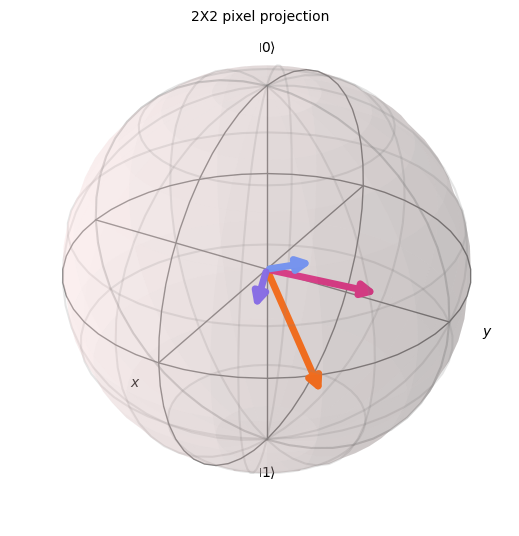

In [148]:
plot_bloch_vector(point_3d, title='2X2 pixel projection')

In [150]:
phis = []
for i in range(len(point_3d)):
    phi = round(np.arctan2(point_3d[i][1],point_3d[i][0]),4)
    phis.append(phi)

phis

[1.1071, 0.7854, 0.7854, 0.4636]

In [164]:
thetas = []
for i in range(len(point_3d)):
    theta = round(np.arccos(point_3d[i][2]),4)
    thetas.append(theta)
thetas

[1.2395, 1.0275, 1.6913, 1.2395]

In [165]:
c = QuantumRegister(1,'c_reg')
pixel = QuantumRegister(2, "Pixel")
tra = QuantumRegister(1, "Transition")
rot = QuantumRegister(1, "Rotation")
cla = ClassicalRegister(c.size+pixel.size, "Classical")

qc = QuantumCircuit(c,pixel,tra,rot,cla)

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


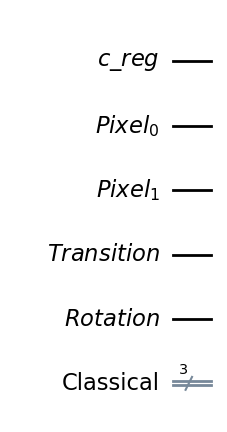

In [166]:
qc.draw('mpl')

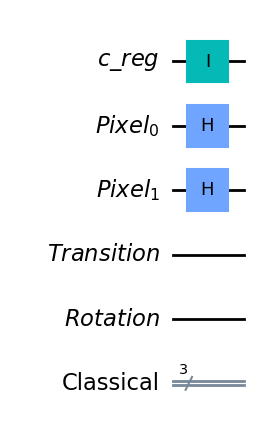

In [167]:
qc.id(c)
qc.h(pixel)
qc.draw('mpl')

In [168]:
coord_q_num = int(np.ceil(math.log(len(point_3d), 2)))

controls_ = []
for i, _ in enumerate(pixel):
    controls_.extend([pixel[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(pixel[k])
                
    qc.barrier()
    # for coord_or_intns in (0,1):
    qc.mcry(theta=theta,
                  q_controls=controls_,
                  q_target=c[0])

    qc.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(pixel[k])
           
    qc.barrier()

qc.measure(list(reversed(range(qc.num_qubits-2))), list(range(cla.size)))

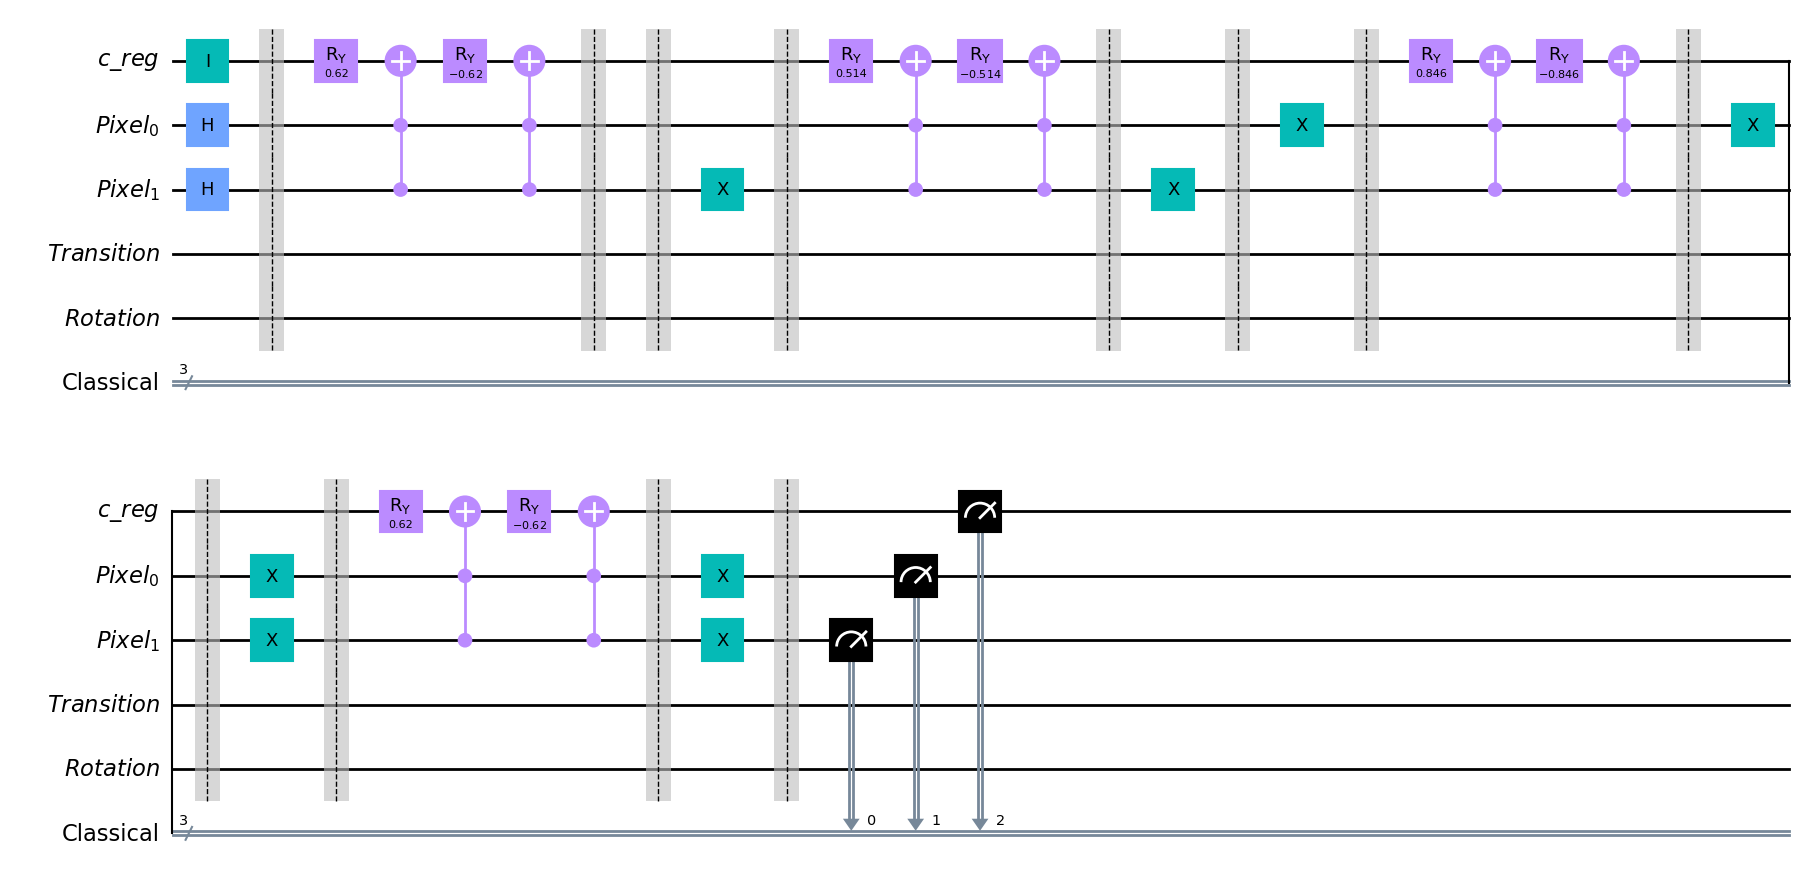

In [169]:
qc.draw('mpl')

In [170]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()

C:\Users\HCI\AppData\Local\Temp\ipykernel_3944\2176529097.py:4: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


In [171]:
counts_oqim.items()

dict_items([('110', 499), ('011', 1305), ('000', 1414), ('001', 955), ('100', 674), ('101', 1107), ('111', 689), ('010', 1549)])

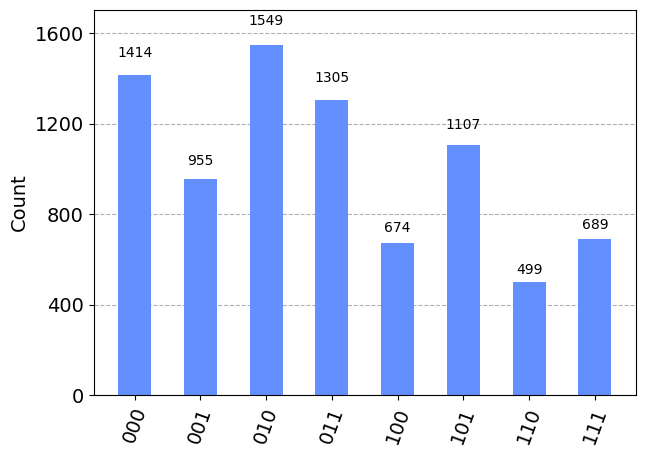

In [172]:
plot_histogram(counts_oqim)

In [173]:
phis

[1.1071, 0.7854, 0.7854, 0.4636]

In [176]:
theta_re = [np.arccos(1414/np.sqrt(1414**2+674**2)), np.arccos(955/np.sqrt(955**2+1107**2)),
            np.arccos(1549/np.sqrt(1549**2+499**2)),np.arccos(1305/np.sqrt(1305**2+689**2))]
phis

point_3d_re = []
for theta, phi in zip(theta_re, phis):
    x = np.cos(phi)
    y = np.sin(phi)
    z = np.cos(theta)
    point_3d_re.append(np.array([x,y,z]))

point_3d_re

[array([0.44725717, 0.8944054 , 0.90269525]),
 array([0.70710548, 0.70710808, 0.65321019]),
 array([0.70710548, 0.70710808, 0.95183017]),
 array([0.89444848, 0.44717101, 0.88431481])]

scaled_point_3d = [array([0.33199833, 0.6639158 , 0.67006934]), array([0.59199819, 0.59200036, 0.54687633]), array([0.51218276, 0.51218465, 0.68944594]), array([0.67003877, 0.33497951, 0.66244756])]


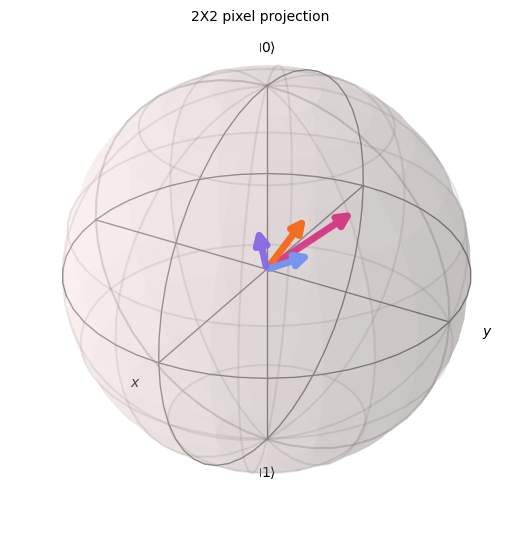

In [177]:
scaled_point_3d_re = []
size_list = []

for i in range(len(point_3d_re)):
    size = np.linalg.norm(point_3d_re[i])
    resize = point_3d_re[i]*(1/size)
    scaled_point_3d_re.append(resize)
    size_list.append(size)

print("scaled_point_3d =", scaled_point_3d_re)
plot_bloch_vector(scaled_point_3d_re, title='2X2 pixel projection')

[0.4229006143144684, 0.3026453503682695, 0.7019798636185244, 0.4229006143144684]
[0.4229006143144684, 0.3026453503682695, 0.7019798636185244, 0.4229006143144684]
[0.4229006143144684, 0.3026453503682695, 0.7019798636185244, 0.4229006143144684]
[0.4229006143144684, 0.3026453503682695, 0.7019798636185244, 0.4229006143144684]
backward_Q = [array([1.05759404, 2.11493049, 0.        ]), array([2.33641614, 2.33642473, 0.        ]), array([1.00730166, 1.00730536, 0.        ]), array([2.11503235, 1.05739031, 0.        ])]


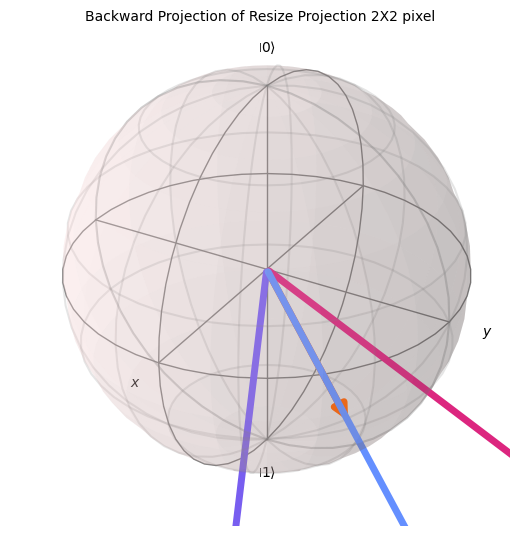

In [178]:
backward_Q_re = []
for i in range(len(scaled_point_3d_re)):
    backward = scaled_point_3d_re[i] * (size_list[i]) * (1/k_list[i])
    print(k_list)
    backward_Q_re.append(np.array([backward[0], backward[1], 0]))


print("backward_Q =", backward_Q_re)
plot_bloch_vector(backward_Q_re, title='Backward Projection of Resize Projection 2X2 pixel')

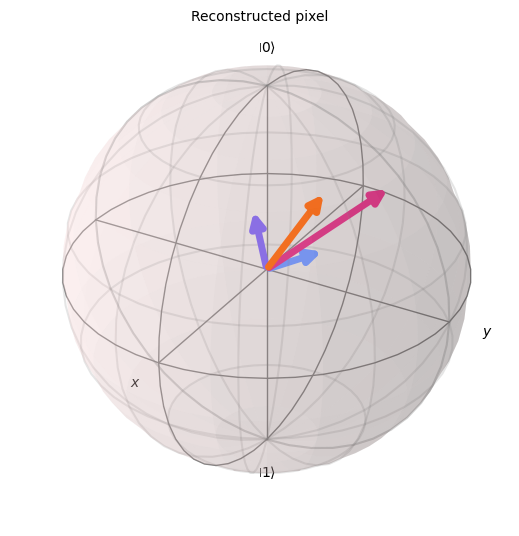

In [179]:
plot_bloch_vector(point_3d_re, title ='Reconstructed pixel')

In [180]:
theta_reconstruct = []
for i in range(0, len(scaled_point_3d_re)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
            
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = round(np.arccos((color_amount/sum(n for _, n in color_list))**(1/2)),4)
        theta_reconstruct.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(theta_reconstruct))
print(classical_colors, '\n', scaled_point_3d_re)

[0.6284, 0.5162, 0.8223, 0.6043] 
 [array([0.33199833, 0.6639158 , 0.67006934]), array([0.59199819, 0.59200036, 0.54687633]), array([0.51218276, 0.51218465, 0.68944594]), array([0.67003877, 0.33497951, 0.66244756])]


In [181]:
phis

[1.1071, 0.7854, 0.7854, 0.4636]

## Simulate Ours in Qiskit

x,y,z =  1 2 0
r =  0.7979  k =  0.3374
x,y,z =  2 2 0
r =  0.7979  k =  0.2415
x,y,z =  1 1 0
r =  0.7979  k =  0.5601
x,y,z =  2 1 0
r =  0.7979  k =  0.3374
0.03637 sec
scaled_point_3d = [array([0.40596218, 0.81182548, 0.41968334]), array([0.56075782, 0.56075988, 0.60917897]), array([0.6794074 , 0.67940989, 0.27714218]), array([0.81059947, 0.4052515 , 0.4227289 ])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_13580\3922335954.py:67: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


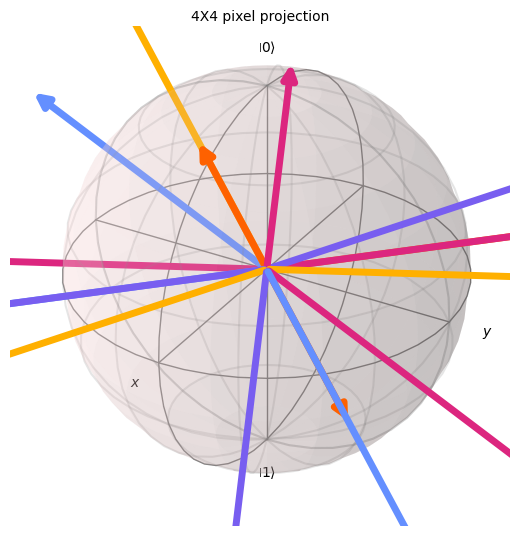

In [24]:
Q = np.array([[1,2,0],[2,2,0],
              [1,1,0],[2,1,0]])

point_2d = []
point_3d = []
k_list = []

start = time.time()

for i in Q:
    sphere = project(i,2)
    point_2d.append(i)
    point_3d.append(sphere)

phis = []
for i in range(len(point_3d)):
    phi = round(np.arctan2(point_3d[i][1],point_3d[i][0]),4)
    phis.append(phi)


thetas = []
for i in range(len(point_3d)):
    theta = round(np.arccos(point_3d[i][2]),4)
    thetas.append(theta)



c = QuantumRegister(1,'c_reg')
pixel = QuantumRegister(2, "Pixel")
tra = QuantumRegister(1, "Transition")
rot = QuantumRegister(1, "Rotation")
cla = ClassicalRegister(c.size+pixel.size, "Classical")
qc = QuantumCircuit(c,pixel,tra,rot,cla)
qc.id(c)
qc.h(pixel)

coord_q_num = int(np.ceil(math.log(len(point_3d), 2)))
controls_ = []
for i, _ in enumerate(pixel):
    controls_.extend([pixel[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(pixel[k])
                
    qc.barrier()
    # for coord_or_intns in (0,1):
    qc.mcry(theta=theta,
                  q_controls=controls_,
                  q_target=c[0])

    qc.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(pixel[k])
           
    qc.barrier()

qc.measure(list(reversed(range(qc.num_qubits-2))), list(range(cla.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()

point_3d_re = []
theta_re = []

for i in range(0, len(Q)):
    pixel_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            pixel_list.append((key[0], amount))
    pixel_amount = 0
    for theta, amount in pixel_list:
        if int(theta):
            pixel_amount=pixel_amount+amount
    try:
        theta = np.arccos((pixel_amount/np.sqrt(sum(n**2 for _, n in pixel_list))))
        theta_re.append(theta)
    except ZeroDivisionError:
        print("ZeroDivisionError")


for theta, phi in zip(theta_re, phis):
    x = np.cos(phi)
    y = np.sin(phi)
    z = np.cos(theta)
    point_3d_re.append(np.array([x,y,z]))

scaled_point_3d_re = []
size_list = []

for i in range(len(point_3d_re)):
    size = np.linalg.norm(point_3d_re[i])
    resize = point_3d_re[i]*(1/size)
    scaled_point_3d_re.append(resize)
    size_list.append(size)

end = time.time()

backward_Q_re = []
for i in range(len(scaled_point_3d_re)):
    backward = scaled_point_3d_re[i] * (size_list[i]) * (1/k_list[i])
    backward_Q_re.append(np.array([backward[0], backward[1], 0]))

for i in range(len(backward_Q_re)):
    x = backward_Q_re[i][0]
    y = backward_Q_re[i][1]
    backward_Q_re.append(np.array([-x,y,0]))
    backward_Q_re.append(np.array([x,-y,0]))
    backward_Q_re.append(np.array([-x,-y,0]))

print(f"{end - start:.5f} sec")
print("scaled_point_3d =", scaled_point_3d_re)
plot_bloch_vector(backward_Q_re, title='4X4 pixel projection')

x,y,z =  1 1 0
r =  0.3989  k =  0.2414
0.03558 sec
scaled_point_3d = [array([7.07105483e-01, 7.07108080e-01, 6.12323400e-17])]


C:\Users\HCI\AppData\Local\Temp\ipykernel_13580\1389012007.py:66: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


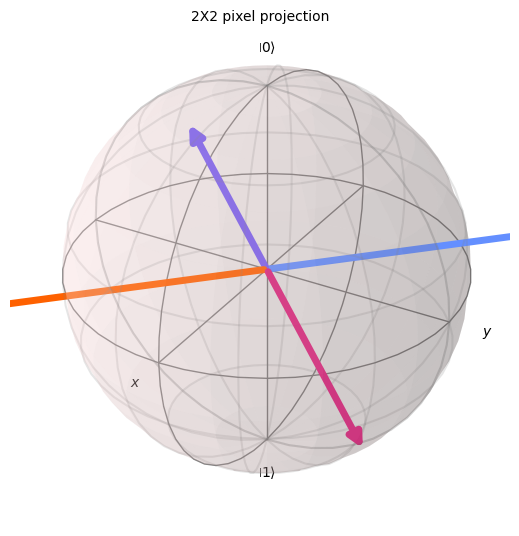

In [25]:
Q = np.array([[1,1,0]])

point_2d = []
point_3d = []
k_list = []

start = time.time()

for i in Q:
    sphere = project(i,1)
    point_2d.append(i)
    point_3d.append(sphere)

phis = []
for i in range(len(point_3d)):
    phi = round(np.arctan2(point_3d[i][1],point_3d[i][0]),4)
    phis.append(phi)


thetas = []
for i in range(len(point_3d)):
    theta = round(np.arccos(point_3d[i][2]),4)
    thetas.append(theta)



c = QuantumRegister(1,'c_reg')
pixel = QuantumRegister(2, "Pixel")
tra = QuantumRegister(1, "Transition")
rot = QuantumRegister(1, "Rotation")
cla = ClassicalRegister(c.size+pixel.size, "Classical")
qc = QuantumCircuit(c,pixel,tra,rot,cla)
qc.id(c)
qc.h(pixel)

coord_q_num = int(np.ceil(math.log(len(point_3d), 2)))
controls_ = []
for i, _ in enumerate(pixel):
    controls_.extend([pixel[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(pixel[k])
                
    qc.barrier()
    # for coord_or_intns in (0,1):
    qc.mcry(theta=theta,
                  q_controls=controls_,
                  q_target=c[0])

    qc.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(pixel[k])
           
    qc.barrier()

qc.measure(list(reversed(range(qc.num_qubits-2))), list(range(cla.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()

point_3d_re = []
theta_re = []

for i in range(0, len(Q)):
    pixel_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            pixel_list.append((key[0], amount))
    pixel_amount = 0
    for theta, amount in pixel_list:
        if int(theta):
            pixel_amount=pixel_amount+amount
    try:
        theta = np.arccos((pixel_amount/np.sqrt(sum(n**2 for _, n in pixel_list))))
        theta_re.append(theta)
    except ZeroDivisionError:
        print("ZeroDivisionError")


for theta, phi in zip(theta_re, phis):
    x = np.cos(phi)
    y = np.sin(phi)
    z = np.cos(theta)
    point_3d_re.append(np.array([x,y,z]))

scaled_point_3d_re = []
size_list = []

for i in range(len(point_3d_re)):
    size = np.linalg.norm(point_3d_re[i])
    resize = point_3d_re[i]*(1/size)
    scaled_point_3d_re.append(resize)
    size_list.append(size)

end = time.time()

backward_Q_re = []
for i in range(len(scaled_point_3d_re)):
    backward = scaled_point_3d_re[i] * (size_list[i]) * (1/k_list[i])
    backward_Q_re.append(np.array([backward[0], backward[1], 0]))

for i in range(len(backward_Q_re)):
    x = backward_Q_re[i][0]
    y = backward_Q_re[i][1]
    backward_Q_re.append(np.array([-x,y,0]))
    backward_Q_re.append(np.array([x,-y,0]))
    backward_Q_re.append(np.array([-x,-y,0]))

print(f"{end - start:.5f} sec")
print("scaled_point_3d =", scaled_point_3d_re)
plot_bloch_vector(backward_Q_re, title='2X2 pixel projection')

## Simulate Ours in IonQ

x,y,z =  1 2 0
r =  0.7979  k =  0.3374
x,y,z =  2 2 0
r =  0.7979  k =  0.2415
x,y,z =  1 1 0
r =  0.7979  k =  0.5601
x,y,z =  2 1 0
r =  0.7979  k =  0.3374
9.49643 sec
scaled_point_3d = [array([0.39744509, 0.79479338, 0.45862936]), array([0.54953336, 0.54953538, 0.62930434]), array([0.67672253, 0.67672502, 0.28998253]), array([0.80576181, 0.40283295, 0.43413537])]


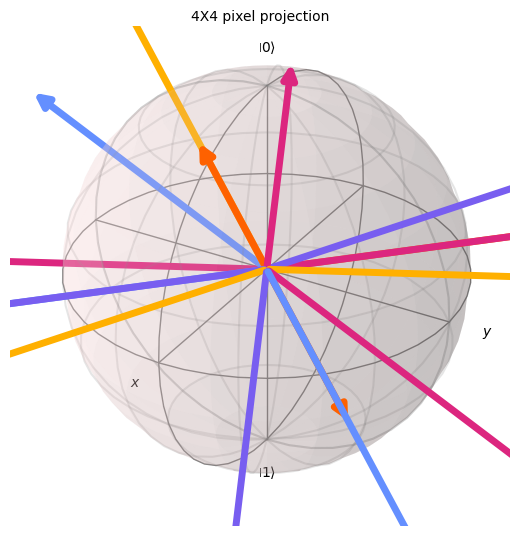

In [5]:
Q = np.array([[1,2,0],[2,2,0],
              [1,1,0],[2,1,0]])

point_2d = []
point_3d = []
k_list = []

start = time.time()

for i in Q:
    sphere = project(i,2)
    point_2d.append(i)
    point_3d.append(sphere)

phis = []
for i in range(len(point_3d)):
    phi = round(np.arctan2(point_3d[i][1],point_3d[i][0]),4)
    phis.append(phi)


thetas = []
for i in range(len(point_3d)):
    theta = round(np.arccos(point_3d[i][2]),4)
    thetas.append(theta)



c = QuantumRegister(1,'c_reg')
pixel = QuantumRegister(2, "Pixel")
tra = QuantumRegister(1, "Transition")
rot = QuantumRegister(1, "Rotation")
cla = ClassicalRegister(c.size+pixel.size, "Classical")
qc = QuantumCircuit(c,pixel,tra,rot,cla)
qc.id(c)
qc.h(pixel)

coord_q_num = int(np.ceil(math.log(len(point_3d), 2)))
controls_ = []
for i, _ in enumerate(pixel):
    controls_.extend([pixel[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(pixel[k])
                
    qc.barrier()
    # for coord_or_intns in (0,1):
    qc.mcry(theta=theta,
                  q_controls=controls_,
                  q_target=c[0])

    qc.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(pixel[k])
           
    qc.barrier()

qc.measure(list(reversed(range(qc.num_qubits-2))), list(range(cla.size)))

simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, simulator_backend)
job_oqim = simulator_backend.run(t_qc_image)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()

point_3d_re = []
theta_re = []

for i in range(0, len(Q)):
    pixel_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            pixel_list.append((key[0], amount))
    pixel_amount = 0
    for theta, amount in pixel_list:
        if int(theta):
            pixel_amount=pixel_amount+amount
    try:
        theta = np.arccos((pixel_amount/np.sqrt(sum(n**2 for _, n in pixel_list))))
        theta_re.append(theta)
    except ZeroDivisionError:
        print("ZeroDivisionError")


for theta, phi in zip(theta_re, phis):
    x = np.cos(phi)
    y = np.sin(phi)
    z = np.cos(theta)
    point_3d_re.append(np.array([x,y,z]))

scaled_point_3d_re = []
size_list = []

for i in range(len(point_3d_re)):
    size = np.linalg.norm(point_3d_re[i])
    resize = point_3d_re[i]*(1/size)
    scaled_point_3d_re.append(resize)
    size_list.append(size)


backward_Q_re = []
for i in range(len(scaled_point_3d_re)):
    backward = scaled_point_3d_re[i] * (size_list[i]) * (1/k_list[i])
    backward_Q_re.append(np.array([backward[0], backward[1], 0]))

for i in range(len(backward_Q_re)):
    x = backward_Q_re[i][0]
    y = backward_Q_re[i][1]
    backward_Q_re.append(np.array([-x,y,0]))
    backward_Q_re.append(np.array([x,-y,0]))
    backward_Q_re.append(np.array([-x,-y,0]))


end = time.time()

print(f"{end - start:.5f} sec")
print("scaled_point_3d =", scaled_point_3d_re)
plot_bloch_vector(backward_Q_re, title='4X4 pixel projection')

x,y,z =  1 1 0
r =  0.3989  k =  0.2414
8.54743 sec
scaled_point_3d = [array([7.07105483e-01, 7.07108080e-01, 6.12323400e-17])]


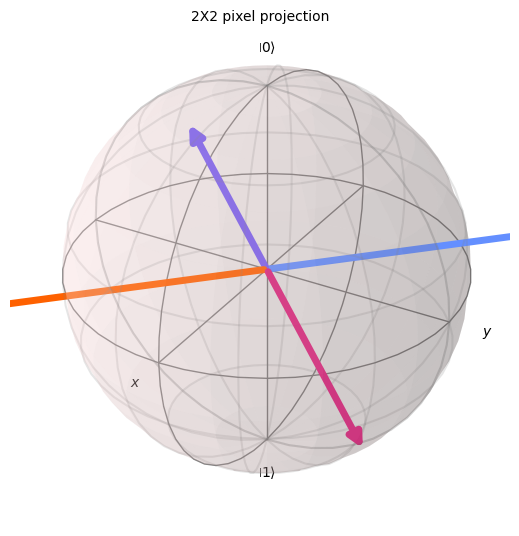

In [6]:
Q = np.array([[1,1,0]])

point_2d = []
point_3d = []
k_list = []

start = time.time()

for i in Q:
    sphere = project(i,1)
    point_2d.append(i)
    point_3d.append(sphere)

phis = []
for i in range(len(point_3d)):
    phi = round(np.arctan2(point_3d[i][1],point_3d[i][0]),4)
    phis.append(phi)


thetas = []
for i in range(len(point_3d)):
    theta = round(np.arccos(point_3d[i][2]),4)
    thetas.append(theta)



c = QuantumRegister(1,'c_reg')
pixel = QuantumRegister(2, "Pixel")
tra = QuantumRegister(1, "Transition")
rot = QuantumRegister(1, "Rotation")
cla = ClassicalRegister(c.size+pixel.size, "Classical")
qc = QuantumCircuit(c,pixel,tra,rot,cla)
qc.id(c)
qc.h(pixel)

coord_q_num = int(np.ceil(math.log(len(point_3d), 2)))
controls_ = []
for i, _ in enumerate(pixel):
    controls_.extend([pixel[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(pixel[k])
                
    qc.barrier()
    # for coord_or_intns in (0,1):
    qc.mcry(theta=theta,
                  q_controls=controls_,
                  q_target=c[0])

    qc.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc.x(pixel[k])
           
    qc.barrier()

qc.measure(list(reversed(range(qc.num_qubits-2))), list(range(cla.size)))

simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, simulator_backend)
job_oqim = simulator_backend.run(t_qc_image)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()

point_3d_re = []
theta_re = []

for i in range(0, len(Q)):
    pixel_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            pixel_list.append((key[0], amount))
    pixel_amount = 0
    for theta, amount in pixel_list:
        if int(theta):
            pixel_amount=pixel_amount+amount
    try:
        theta = np.arccos((pixel_amount/np.sqrt(sum(n**2 for _, n in pixel_list))))
        theta_re.append(theta)
    except ZeroDivisionError:
        print("ZeroDivisionError")


for theta, phi in zip(theta_re, phis):
    x = np.cos(phi)
    y = np.sin(phi)
    z = np.cos(theta)
    point_3d_re.append(np.array([x,y,z]))

scaled_point_3d_re = []
size_list = []

for i in range(len(point_3d_re)):
    size = np.linalg.norm(point_3d_re[i])
    resize = point_3d_re[i]*(1/size)
    scaled_point_3d_re.append(resize)
    size_list.append(size)


backward_Q_re = []
for i in range(len(scaled_point_3d_re)):
    backward = scaled_point_3d_re[i] * (size_list[i]) * (1/k_list[i])
    backward_Q_re.append(np.array([backward[0], backward[1], 0]))

for i in range(len(backward_Q_re)):
    x = backward_Q_re[i][0]
    y = backward_Q_re[i][1]
    backward_Q_re.append(np.array([-x,y,0]))
    backward_Q_re.append(np.array([x,-y,0]))
    backward_Q_re.append(np.array([-x,-y,0]))


end = time.time()

print(f"{end - start:.5f} sec")
print("scaled_point_3d =", scaled_point_3d_re)
plot_bloch_vector(backward_Q_re, title='2X2 pixel projection')

# FRQI

## Simulate FRQI in Qiskit

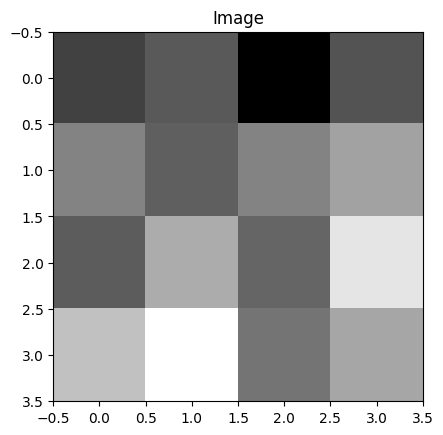

In [12]:
image = np.random.uniform(low=0, high=255, size=(4,4)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [13]:
input_im = image.copy().flatten()
print(input_im)
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
print(thetas)
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))
print(coord_q_num)

[ 79 100  19  94 137 105 137 165 102 174 110 225 193 249 124 169]
[0.48473793 0.61359232 0.11658254 0.57677678 0.84062147 0.64427193
 0.84062147 1.01242732 0.62586416 1.06765063 0.67495155 1.38058271
 1.18423317 1.52784486 0.76085447 1.03697101]
4


In [14]:
start = time.time()

input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=65536)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)


end = time.time()

print(f"{end - start:.5f} sec")

C:\Users\HCI\AppData\Local\Temp\ipykernel_14008\4082740033.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)
C:\Users\HCI\AppData\Local\Temp\ipykernel_14008\4082740033.py:46: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


[76, 101, 18, 93, 135, 106, 133, 162, 100, 174, 110, 224, 194, 251, 123, 169] 
 [ 79 100  19  94 137 105 137 165 102 174 110 225 193 249 124 169]
0.27240 sec


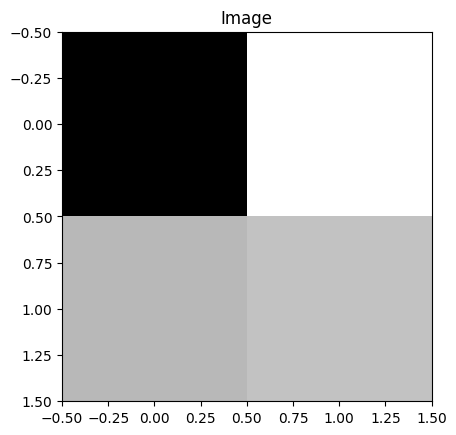

In [15]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [16]:
start = time.time()

input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)


end = time.time()

print(f"{end - start:.5f} sec")

[29, 5, 8, 68] 
 [27  3 11 70]
0.03502 sec


C:\Users\HCI\AppData\Local\Temp\ipykernel_13580\3479715401.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)
C:\Users\HCI\AppData\Local\Temp\ipykernel_13580\3479715401.py:46: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


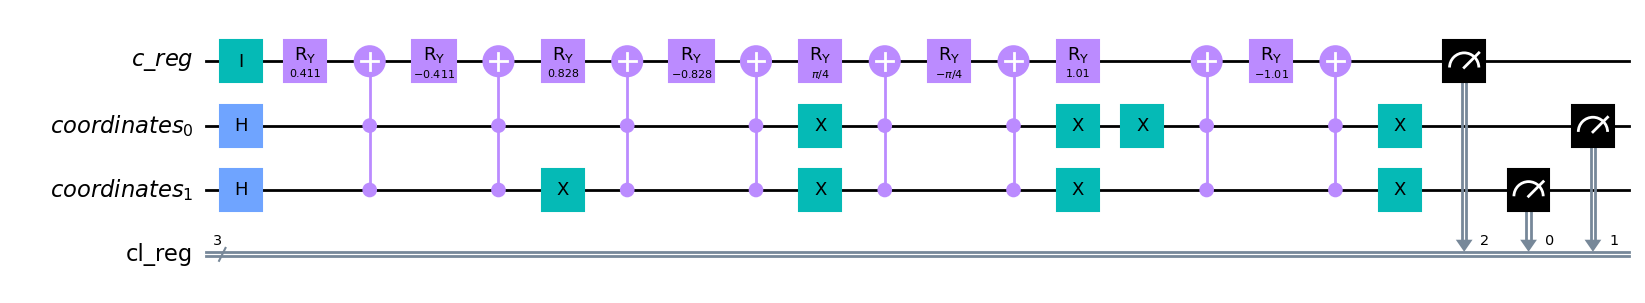

In [5]:
qc_image.draw('mpl')

In [46]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

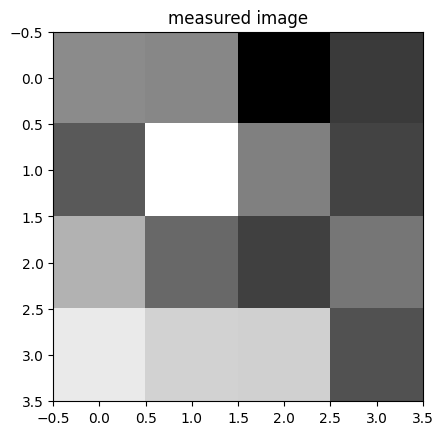

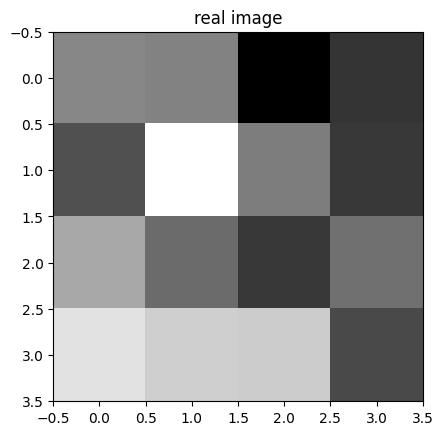

In [185]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

In [48]:
print("Image = ",image, "reconstructed = ",classical_colors)

Image =  [[232  69]
 [213  37]] reconstructed =  [232, 71, 212, 38]


In [67]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

In [68]:
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

C:\Users\HCI\AppData\Local\Temp\ipykernel_3944\2498201748.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


In [69]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 7022, # of qubits is 11


## Simulate FRQI in IonQ

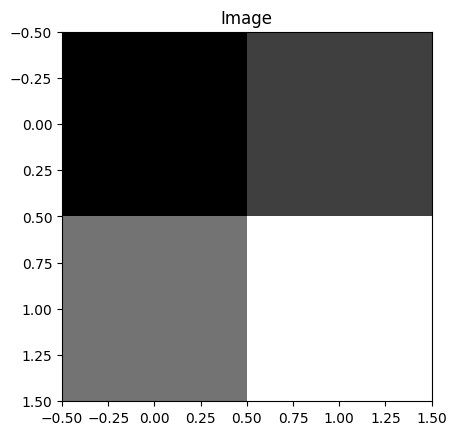

In [167]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

In [58]:
from qiskit.circuit.library import XGate, RYGate

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\3722775345.py:12: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


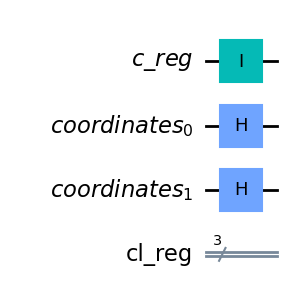

In [168]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2))) 

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.draw('mpl')

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\3066035408.py:12: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)
C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


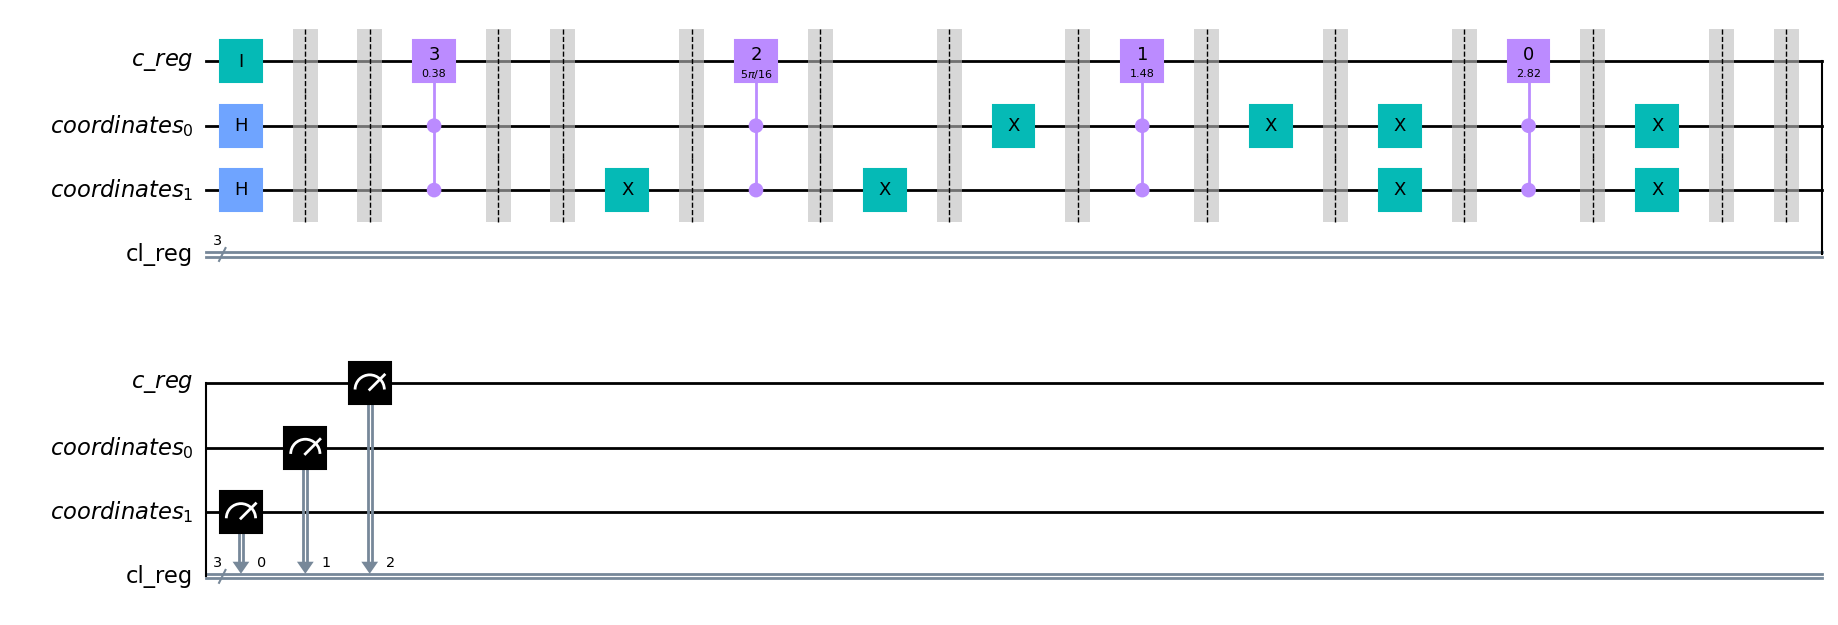

In [170]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2))) 

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.barrier()
controls_ = []

for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    # for coord_or_intns in (0,1):
    cry = RYGate(2 *theta, label=f'{abs(i-3)}').control(2)
    qc_image.append(cry, [2,1,0])
    qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    qc_image.barrier()
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

qc_image.draw('mpl',  scale=1)

In [171]:
start = time.time()

input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []

for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    # for coord_or_intns in (0,1):
    cry = RYGate(2 *theta, label=f'{abs(i-3)}').control(2)
    qc_image.append(cry, [2,1,0])
    qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    qc_image.barrier()
qc_image.barrier()
qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

qc_image.draw('mpl',  scale=1)

simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_oqim = simulator_backend.run(t_qc_image, shots=65536)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)


end = time.time()

print(f"{end - start:.5f} sec")

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\138176179.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


[30, 79, 121, 230] 
 [ 31  80 121 230]
8.90770 sec


In [172]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

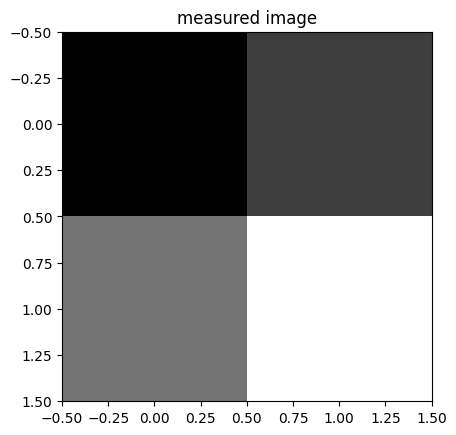

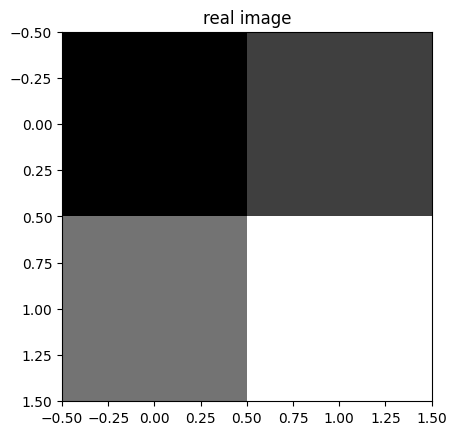

In [173]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

In [11]:
print("Image = ",image, "reconstructed = ",classical_colors)

Image =  [[199  98]
 [141 171]] reconstructed =  [199, 89, 145, 170]


In [4]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

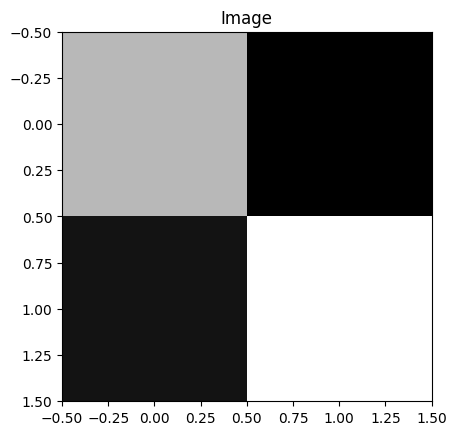

In [3]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

# NEQR

## Simulate NEQR in Qiskit

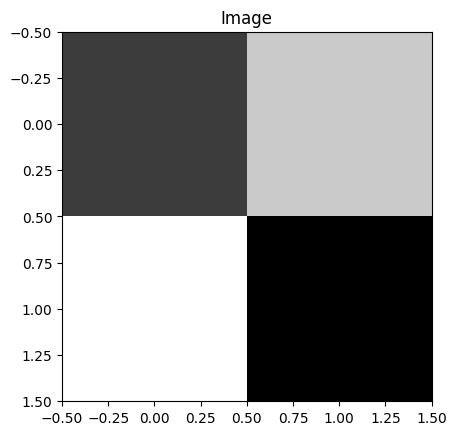

In [257]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\2147603298.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(intensity)


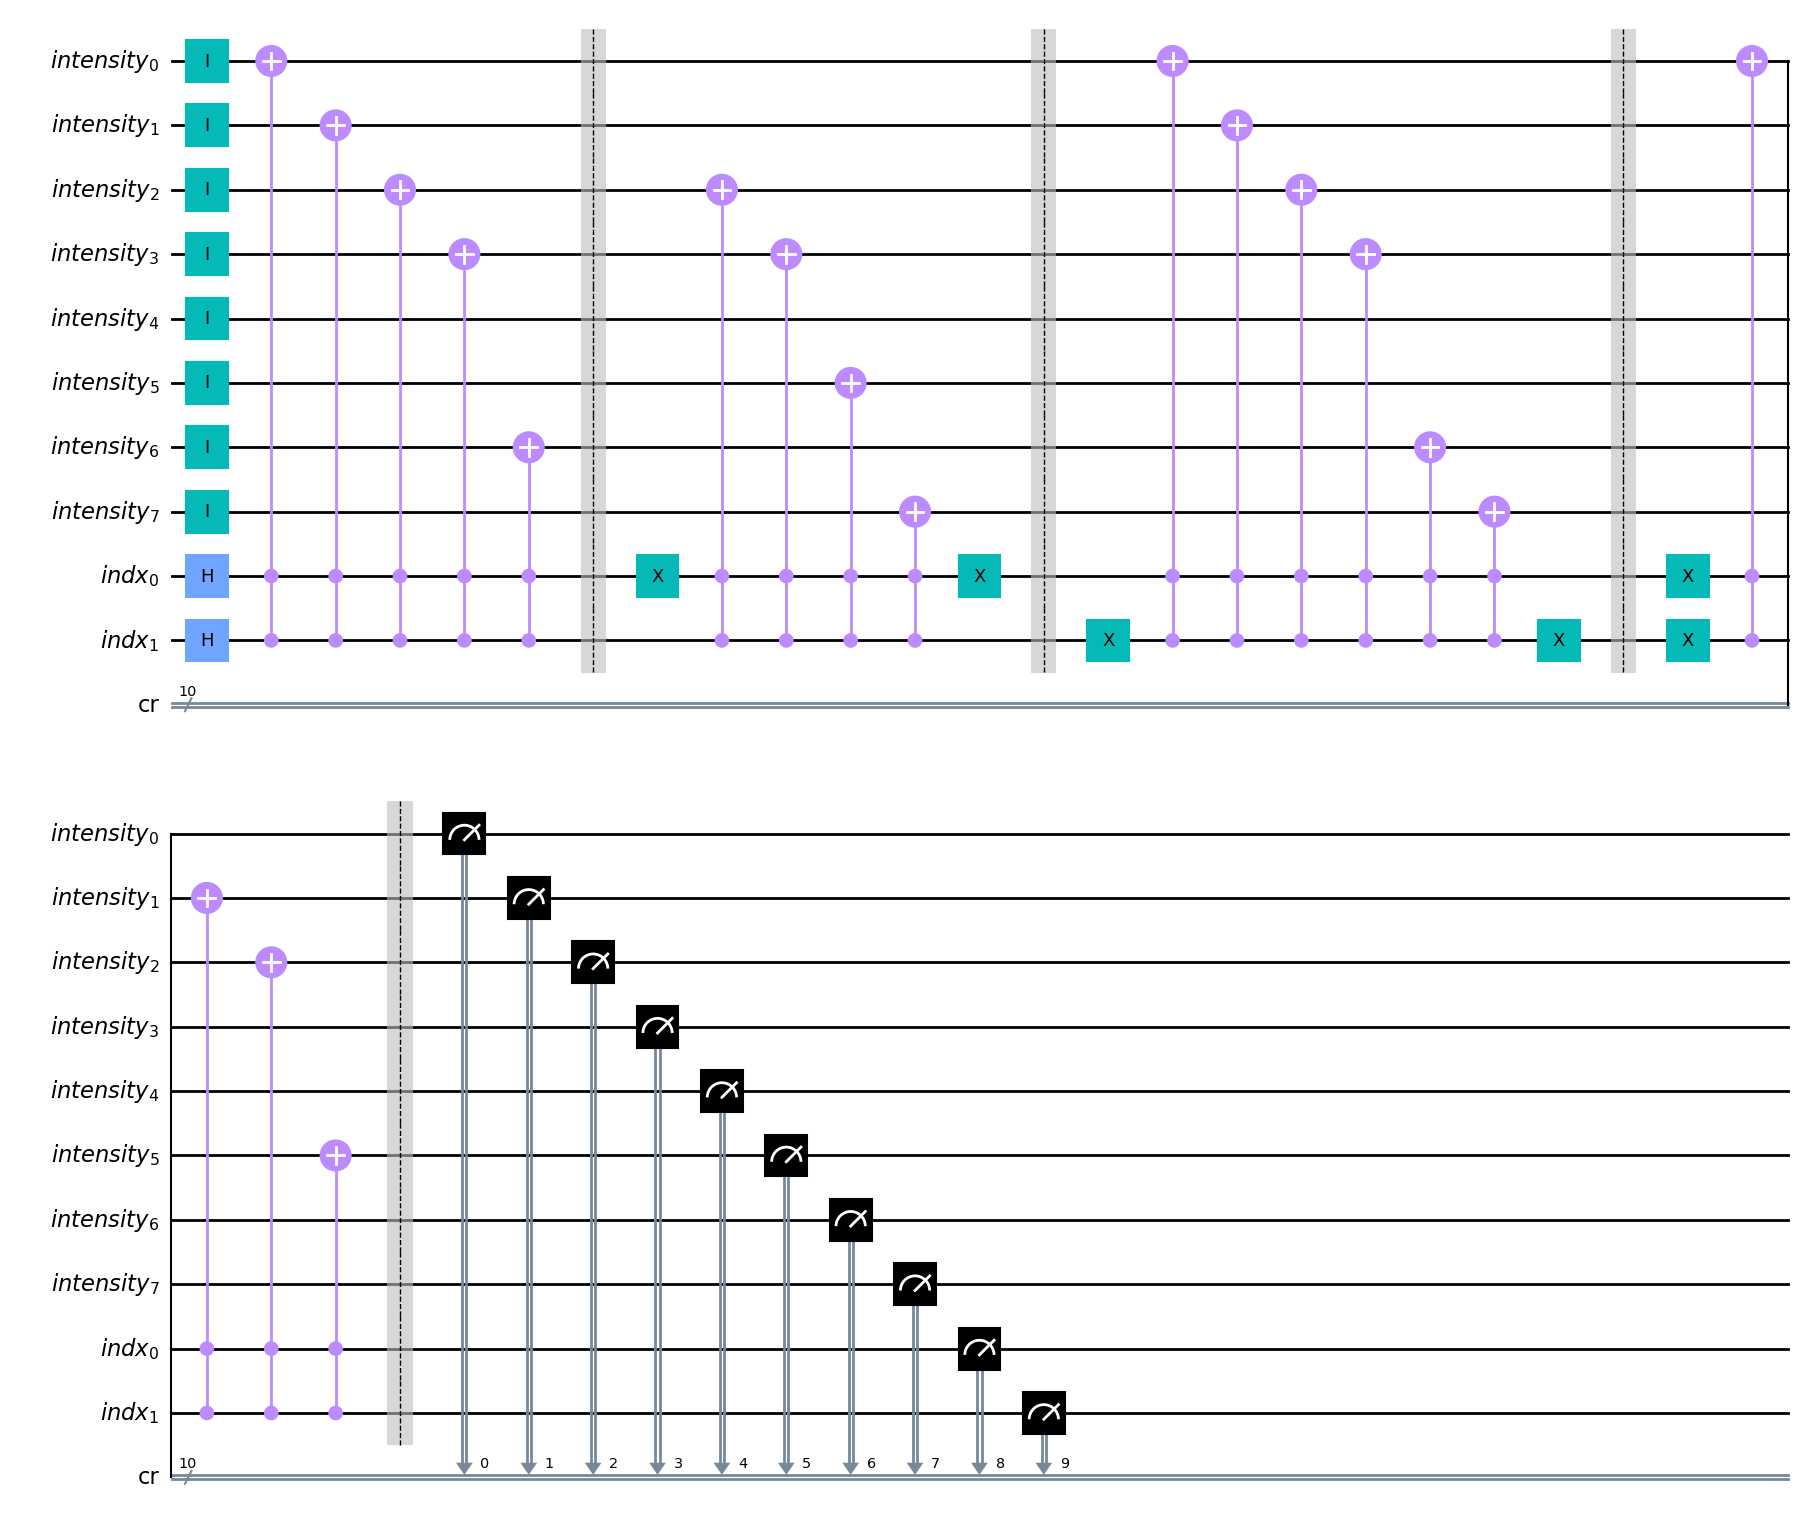

In [258]:
indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits

input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)

for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))

    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)

    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)

    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
                
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))

qc_image.draw('mpl')

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\3849832659.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(intensity)
C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\3849832659.py:32: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_neqr = aer_sim.run(qobj)


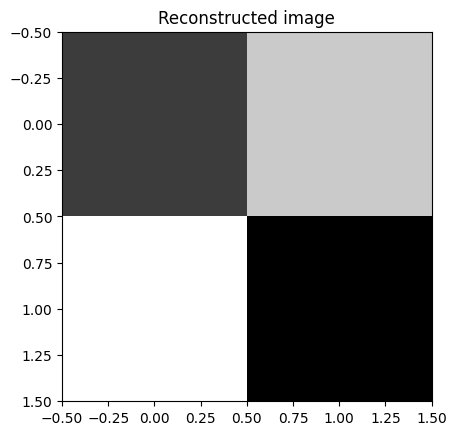

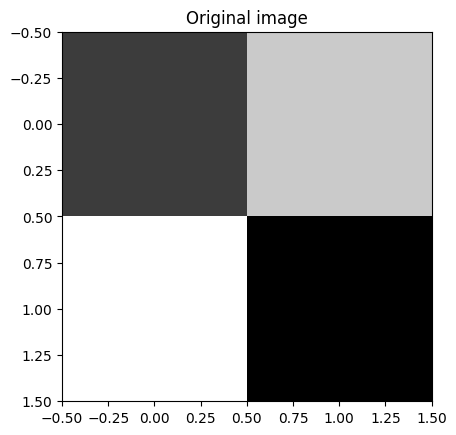

[ 79. 172. 207.  39.] 
 [ 79 172 207  39]
0.38941 sec


In [259]:
start = time.time()

indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=65536)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))

end = time.time()

plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(out_image.flatten(), '\n', image.flatten())

print(f"{end - start:.5f} sec")

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\3849832659.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(intensity)
C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\3849832659.py:32: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_neqr = aer_sim.run(qobj)


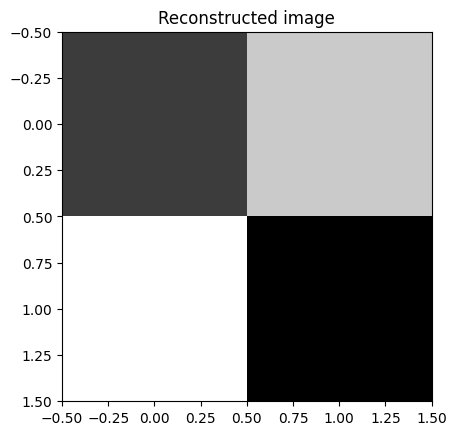

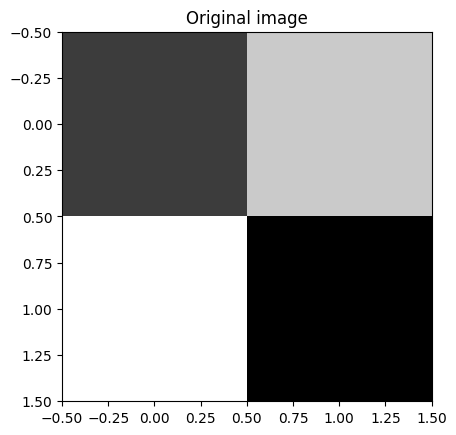

[ 79. 172. 207.  39.] 
 [ 79 172 207  39]
0.39130 sec


In [261]:
start = time.time()

indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=65536)
job_neqr = aer_sim.run(qobj)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))

end = time.time()

plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(out_image.flatten(), '\n', image.flatten())

print(f"{end - start:.5f} sec")

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


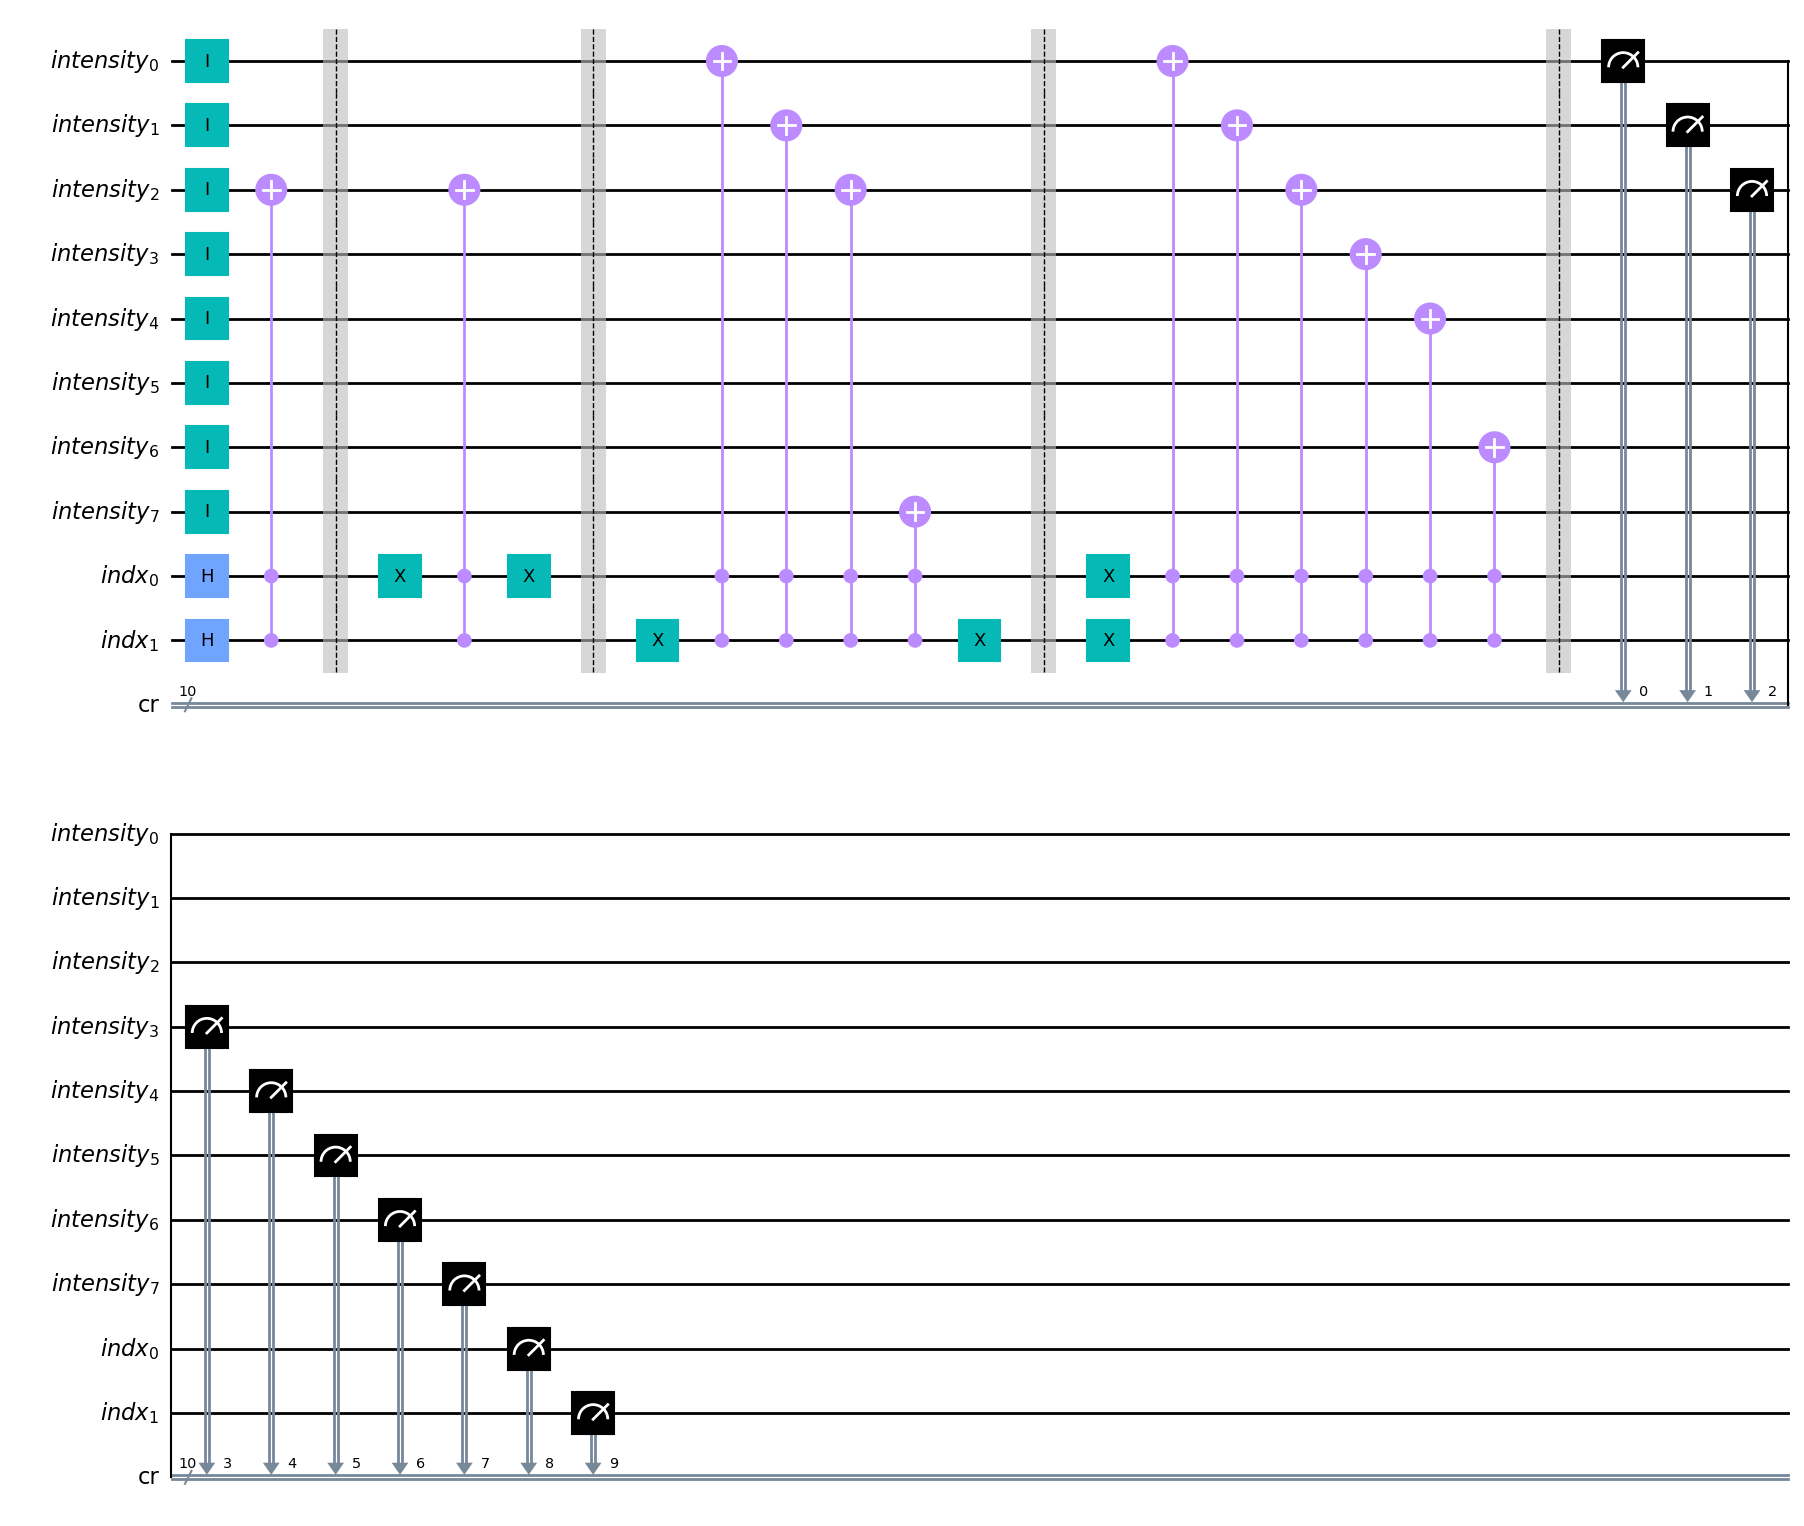

In [177]:
qc_image.draw('mpl')

In [24]:
print("Image = ",image, "reconstructed = ",out_image)

Image =  [[120  74 177  93]
 [117 148 253 104]
 [113  14 231  31]
 [105 179  98  41]] reconstructed =  [[120.  74. 177.  93.]
 [117. 148. 253. 104.]
 [113.  14. 231.  31.]
 [105. 179.  98.  41.]]


## Simulate NEQR in IonQ

In [7]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("api")

In [8]:
simulator_backend = provider.get_backend("ionq_simulator")

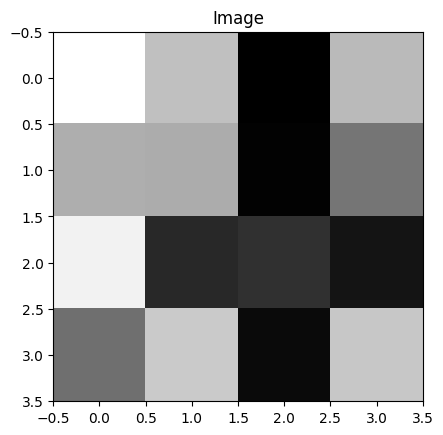

In [25]:
image = np.random.uniform(low=0, high=255, size=(4,4)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

C:\Users\HCI\AppData\Local\Temp\ipykernel_14008\3302269044.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(intensity)


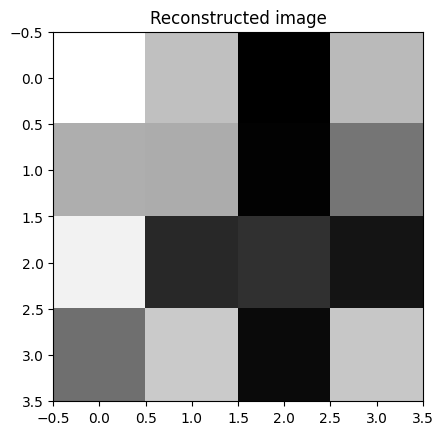

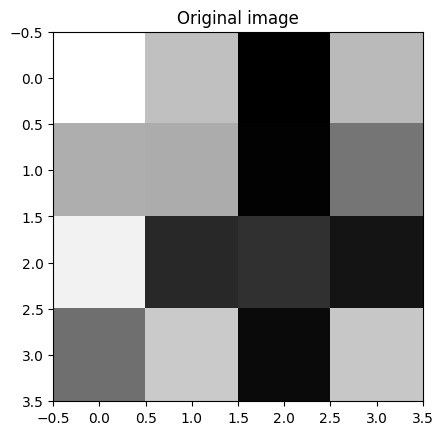

[254. 211.  82. 207. 199. 198.  84. 161. 245. 109. 115.  96. 157. 218.
  89. 216.] 
 [254 211  82 207 199 198  84 161 245 109 115  96 157 218  89 216]
8.97928 sec


In [26]:
start = time.time()

indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)

for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))


simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_neqr = simulator_backend.run(t_qc_image, shots=65536)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()

out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))
plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(out_image.flatten(), '\n', image.flatten())
end = time.time()

print(f"{end - start:.5f} sec")

In [27]:
print("Image = ",image, "reconstructed = ",out_image)

Image =  [[254 211  82 207]
 [199 198  84 161]
 [245 109 115  96]
 [157 218  89 216]] reconstructed =  [[254. 211.  82. 207.]
 [199. 198.  84. 161.]
 [245. 109. 115.  96.]
 [157. 218.  89. 216.]]


# OQIM

## Simulate OQIM in Qiskit

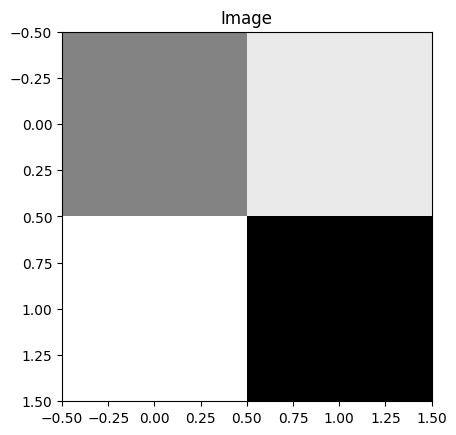

In [178]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

In [179]:
im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1
print(thetas, '\n', phis)

[0.83448555 1.35603902 1.46648563 0.159534  ] 
 [0.         0.39269908 0.78539816 1.17809725]


C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\1742133110.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)
C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


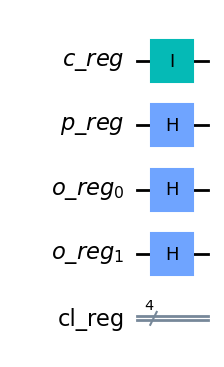

In [180]:
O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c, p, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.h(p)
qc_image.draw('mpl')

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\451763921.py:9: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


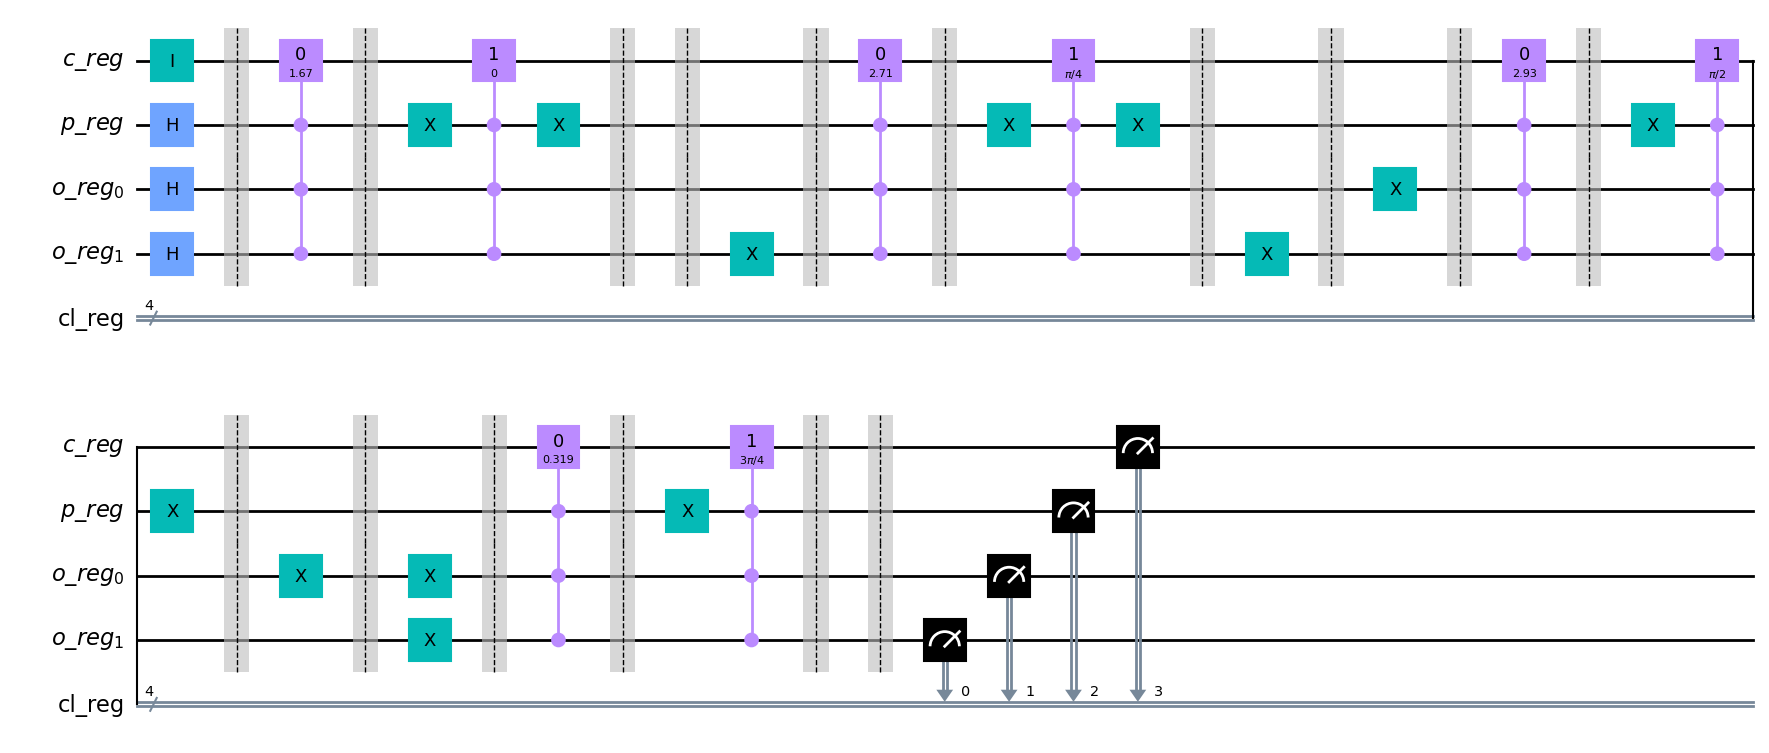

In [181]:
O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c, p, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.h(p)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            cry = RYGate(2 *theta, label=f'{coord_or_intns}').control(3)
            qc_image.append(cry, [3,2,1,0])
            qc_image.barrier()
        else:
            qc_image.x(p)
            cry = RYGate(2 *phi, label=f'{coord_or_intns}').control(3)
            qc_image.append(cry, [3,2,1,0])      
            if i!=len(thetas) - 1:
                qc_image.x(p)
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

qc_image.draw('mpl')

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\2368185494.py:22: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)
C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\2368185494.py:67: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  job_oqim = aer_sim.run(qobj)


the meauserd colors are 
 [ 74 174  27 217] 
 the input colors are 
 [ 71 178  28 217]
the meauserd coordinates are 
 [0 0 2 2]


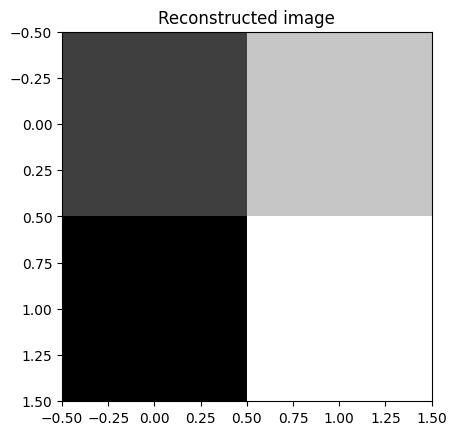

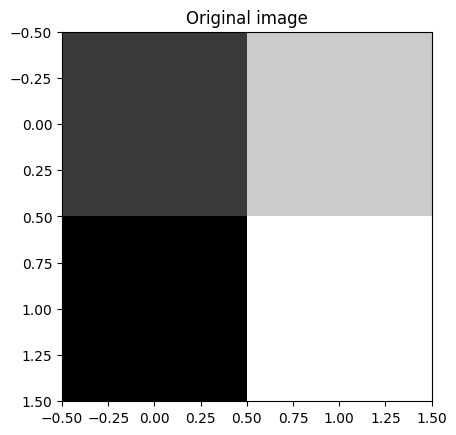

[ 74 174  27 217] 
 [ 71 178  28 217]
0.06981 sec


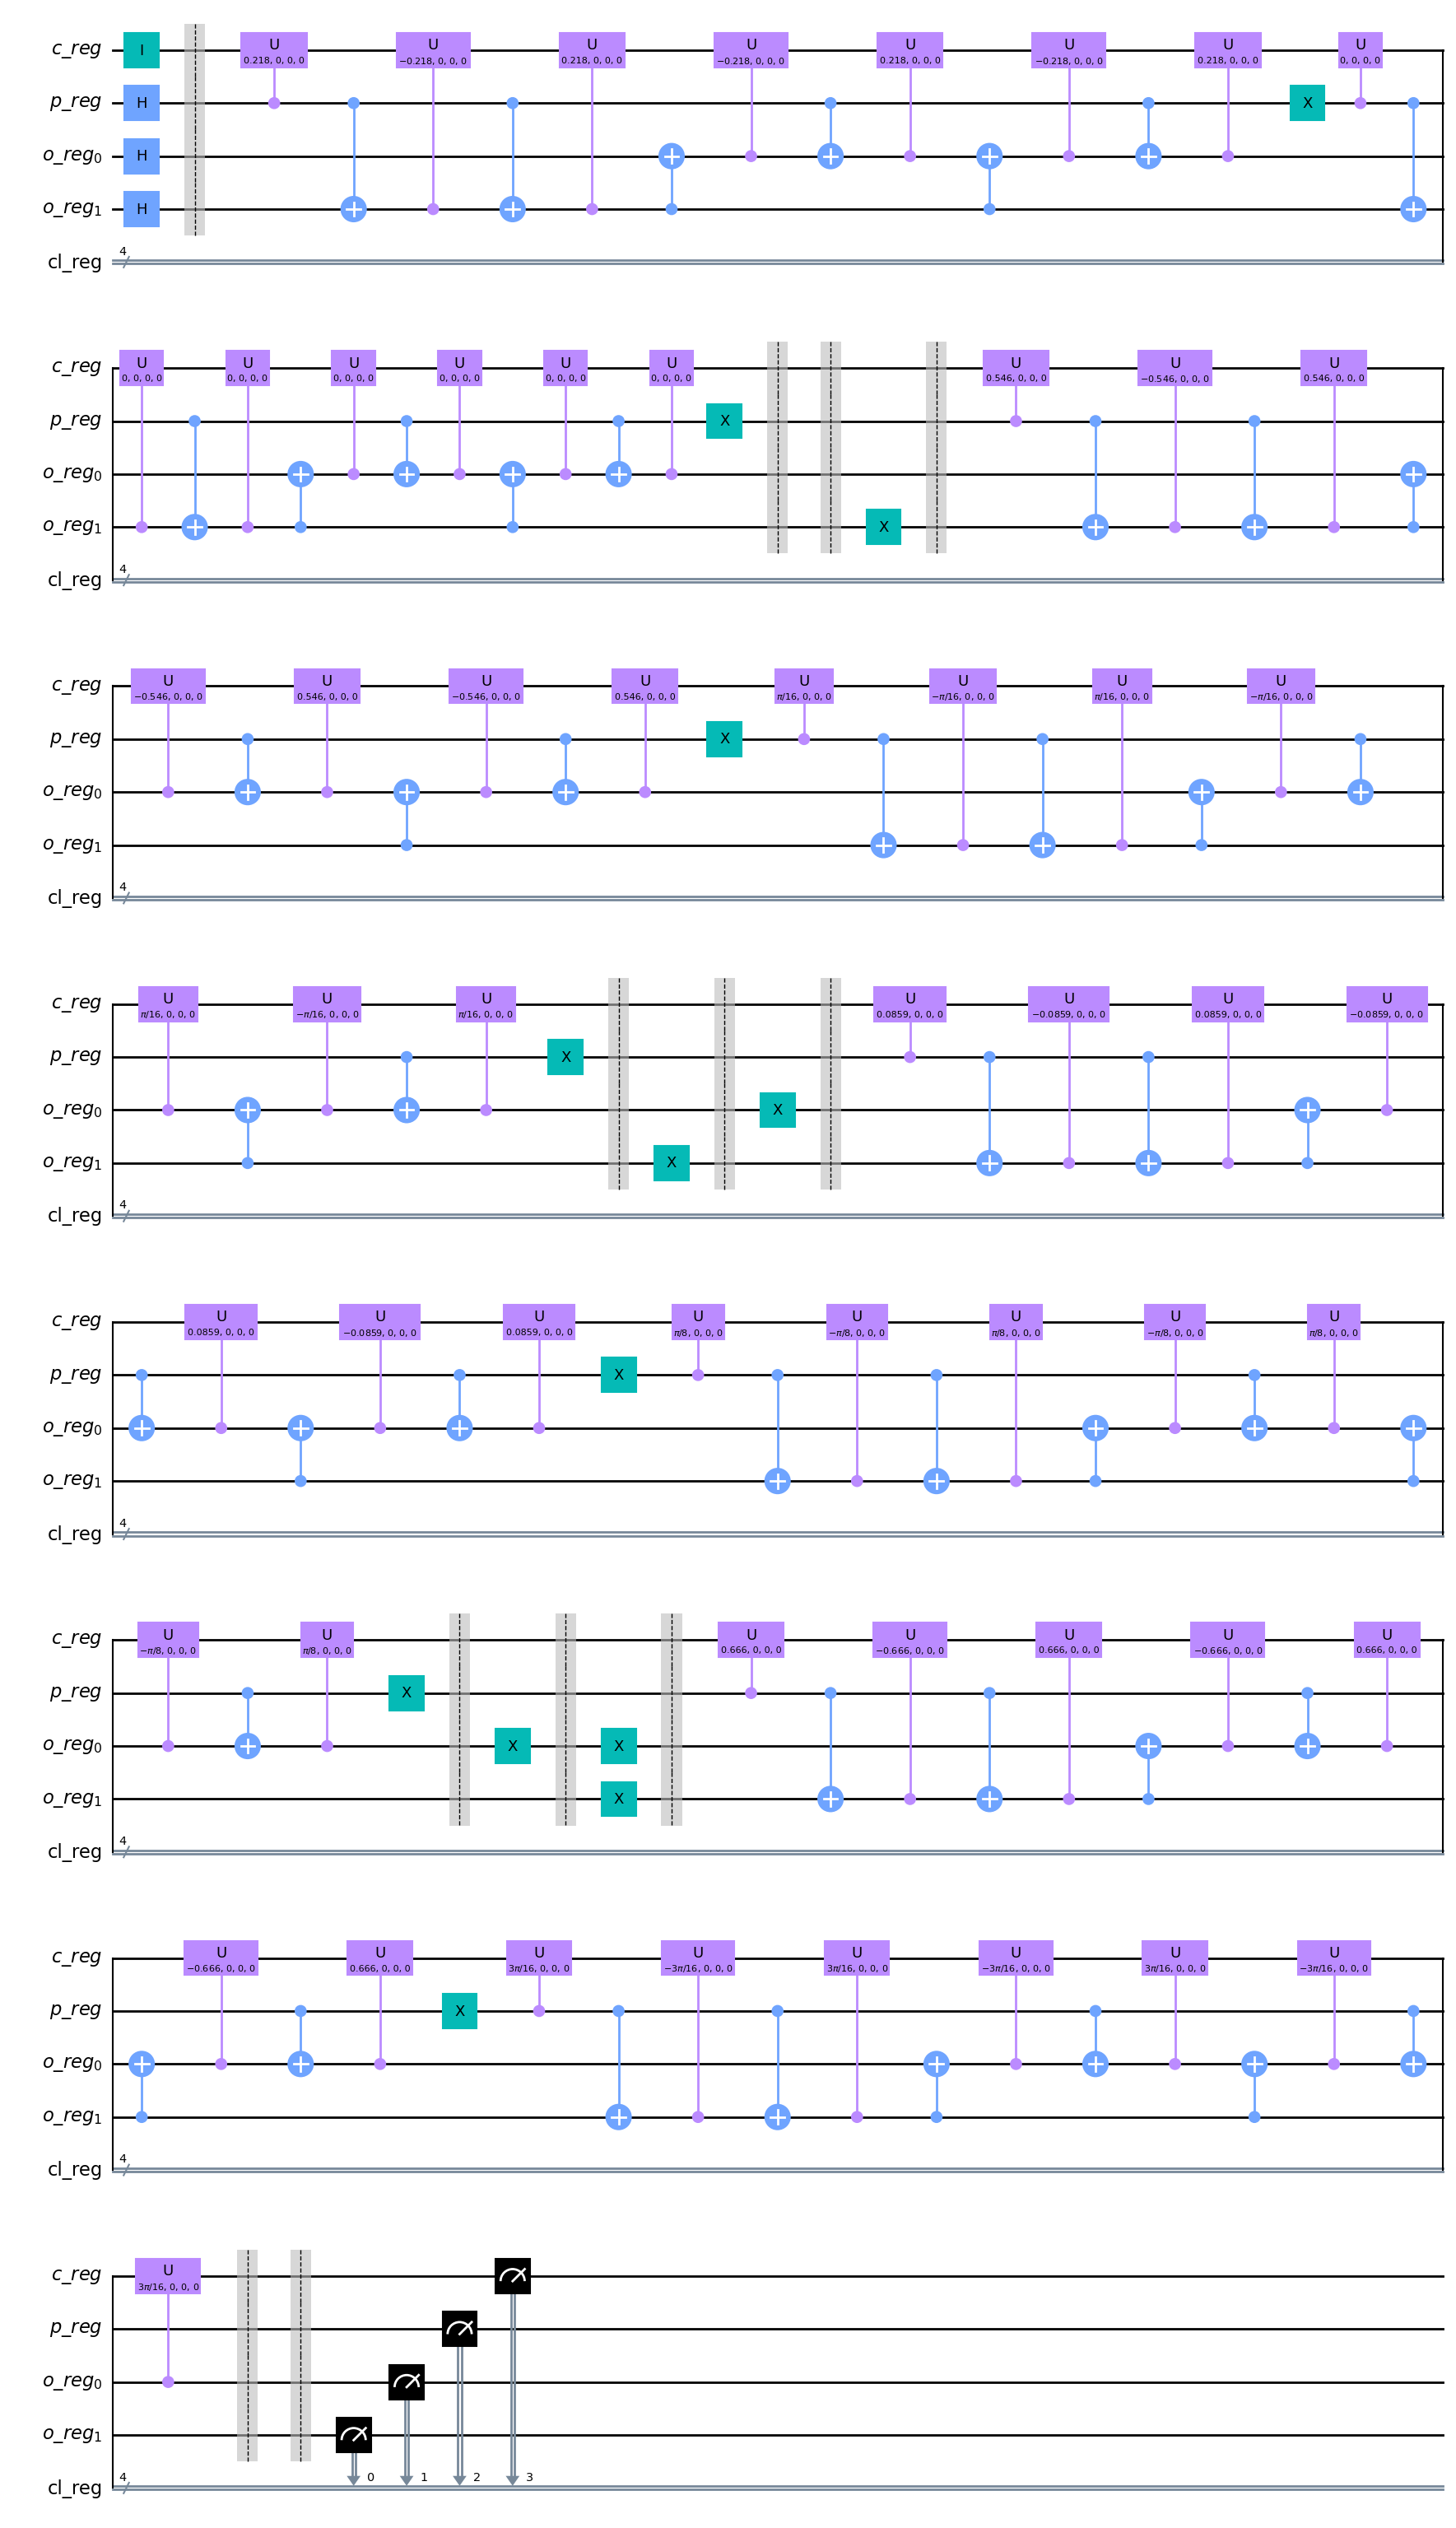

In [106]:
start = time.time()

im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c, p, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.h(p)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
qobj = assemble(t_qc_image, shots=8192)
job_oqim = aer_sim.run(qobj)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            if not int(key[1]):
                color_list.append((key[0], amount))
            else:
                coord_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
print('the meauserd colors are \n {} \n the input colors are \n {}'.format(classical_colors, im_list))
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
print('the meauserd coordinates are \n {}'.format(classical_coords))
output_im = classical_colors.reshape(image.shape)

end = time.time()

plt.imshow(output_im, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(output_im.flatten(), '\n', image.flatten())

print(f"{end - start:.5f} sec")
qc_image.draw('mpl')

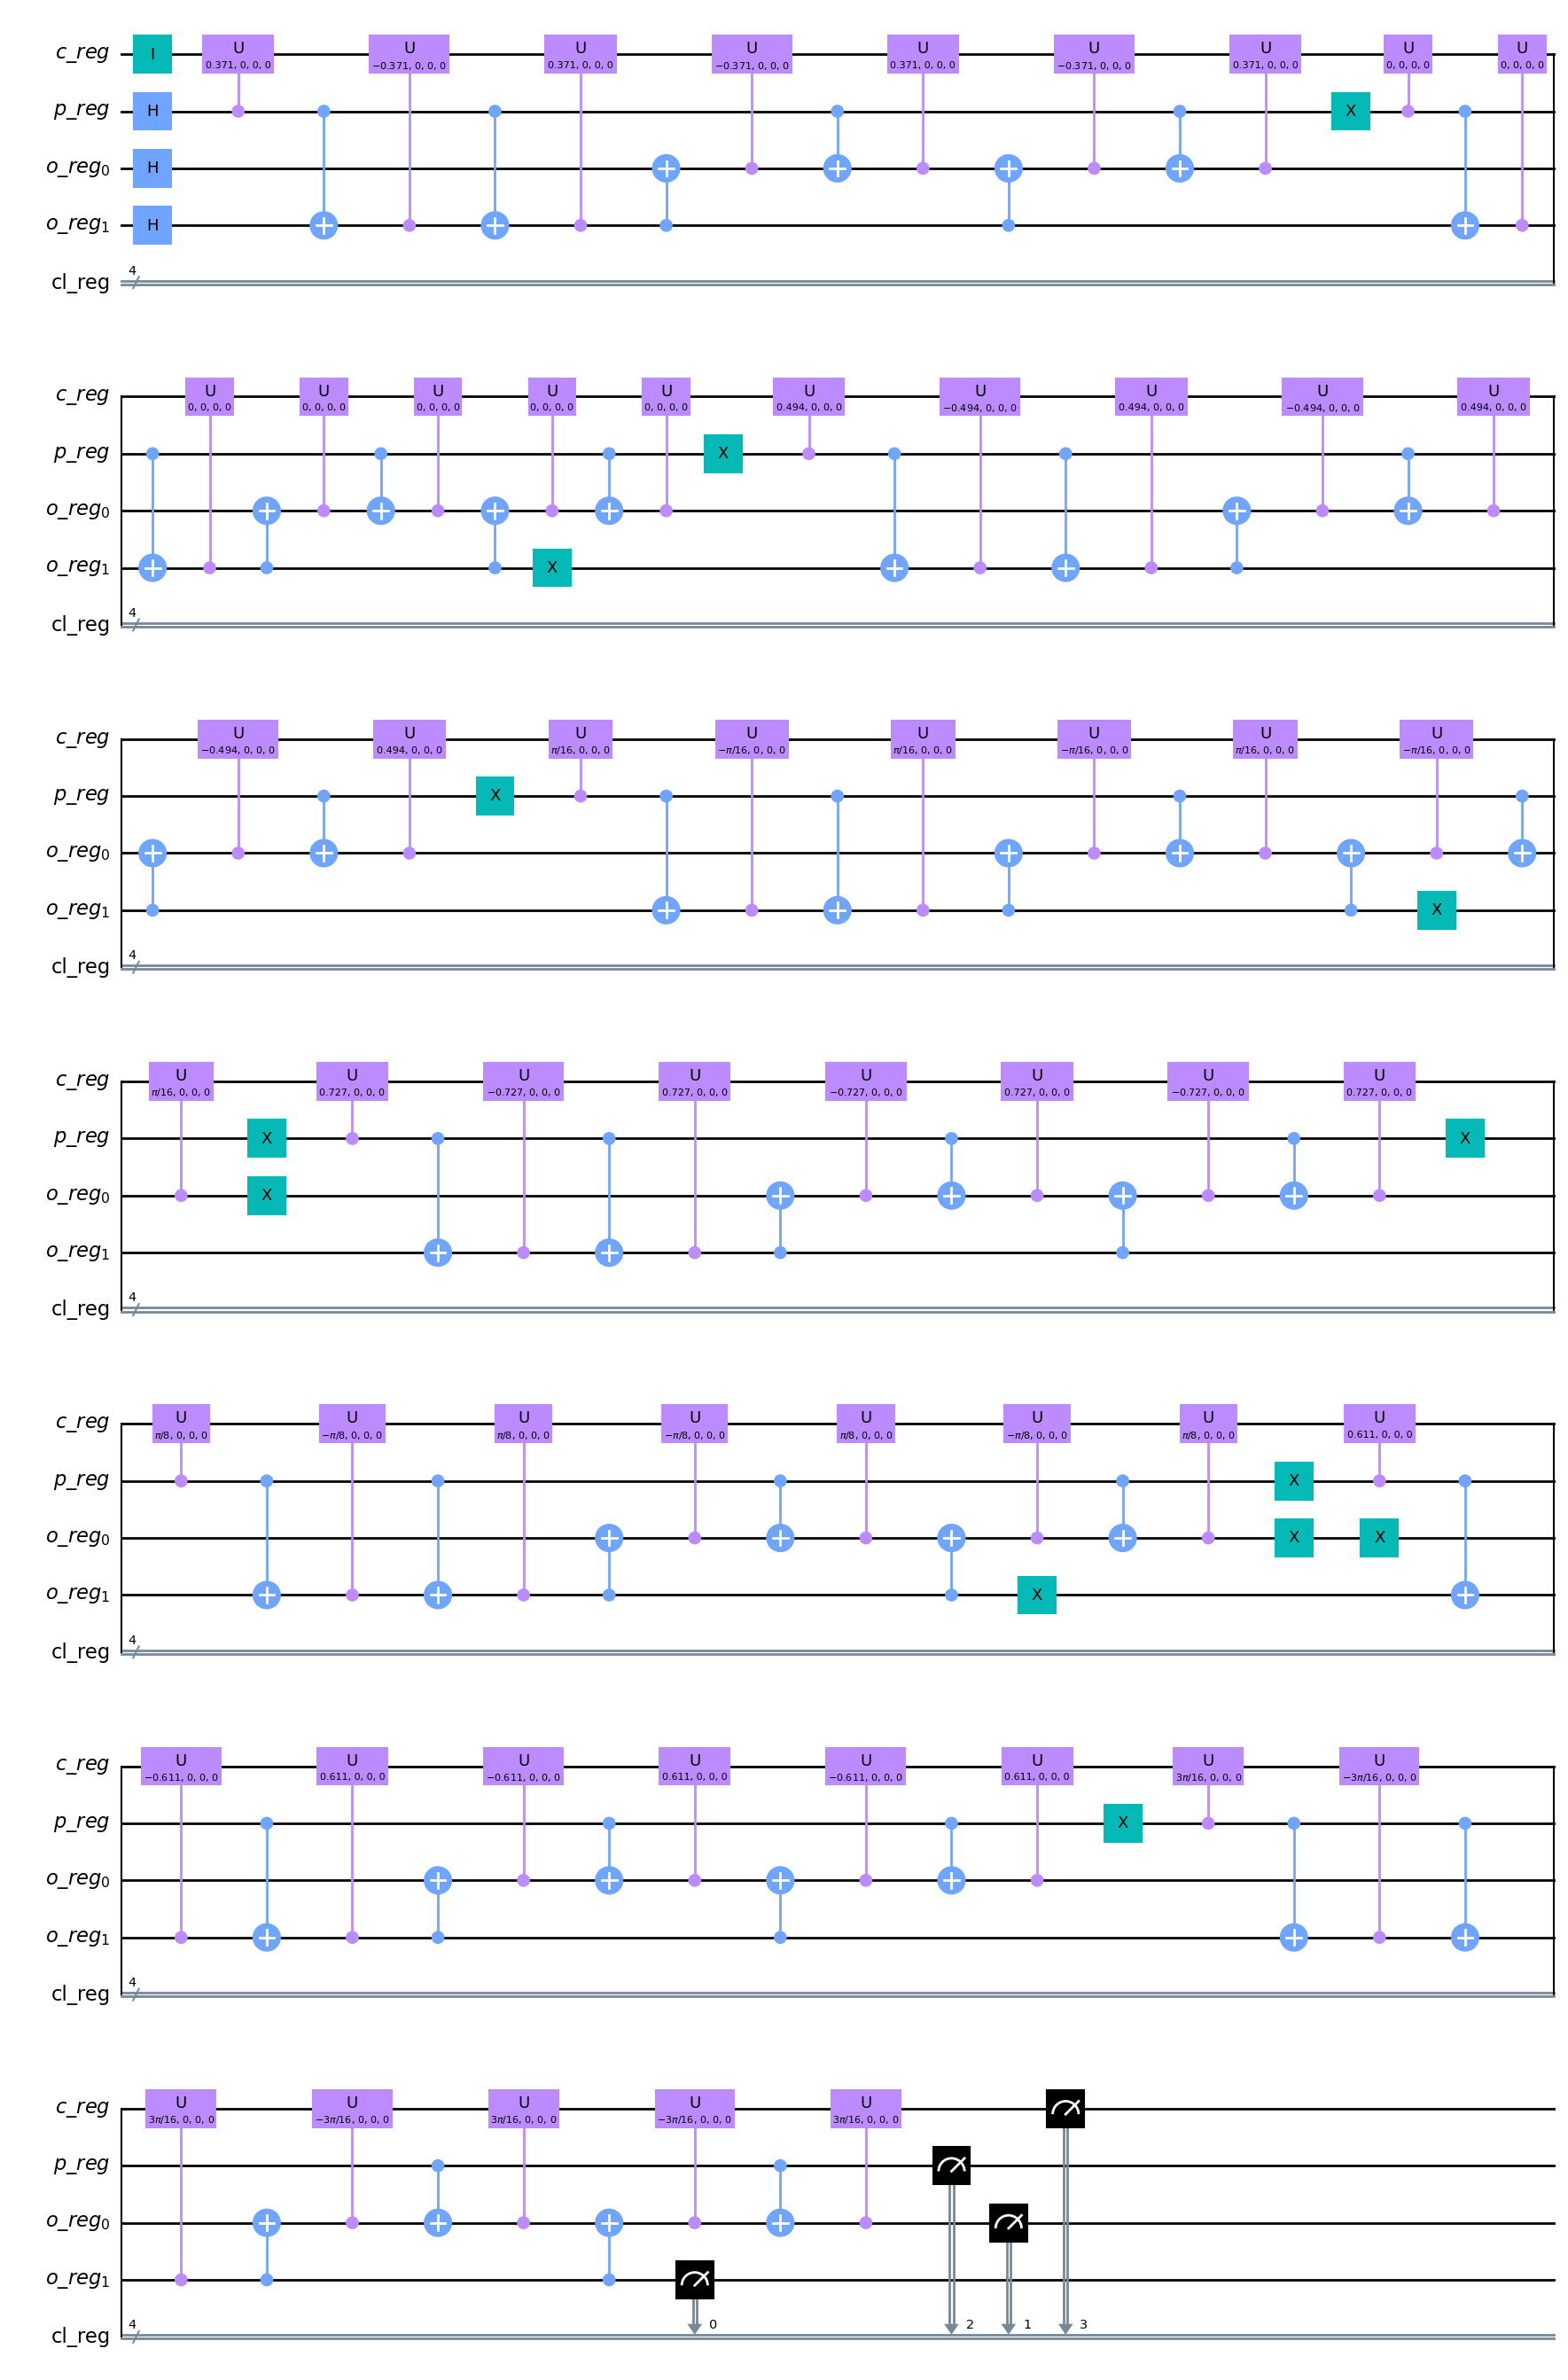

In [8]:
qc_image.draw('mpl')

## Simulate OQIM in IonQ

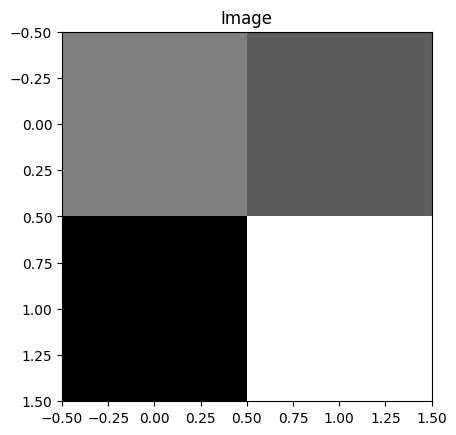

In [53]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

C:\Users\HCI\AppData\Local\Temp\ipykernel_5016\1646045408.py:22: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


the meauserd colors are 
 [132 123  50 223] 
 the input colors are 
 [140 117  55 224]
the meauserd coordinates are 
 [0 1 2 2]


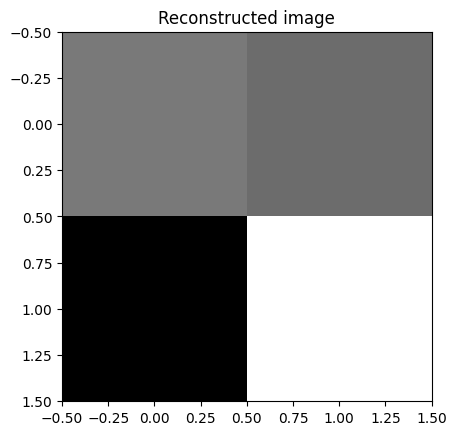

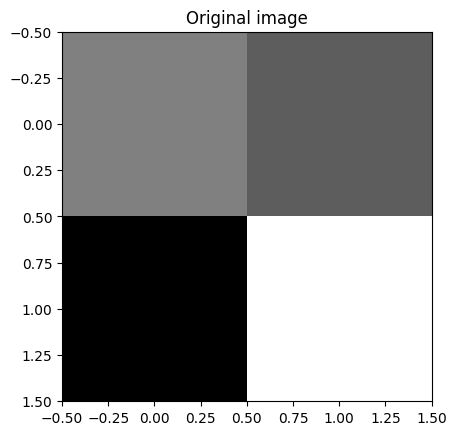

[132 123  50 223] 
 [140 117  55 224]
8.92709 sec


In [54]:
start = time.time()

im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))

num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c, p, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.h(p)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
       
    # qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_oqim = simulator_backend.run(t_qc_image)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()

classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            if not int(key[1]):
                color_list.append((key[0], amount))
            else:
                coord_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
print('the meauserd colors are \n {} \n the input colors are \n {}'.format(classical_colors, im_list))
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
print('the meauserd coordinates are \n {}'.format(classical_coords))
output_im = classical_colors.reshape(image.shape)

end = time.time()

plt.imshow(output_im, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(output_im.flatten(), '\n', image.flatten())

print(f"{end - start:.5f} sec")

# MCQRI

## Simulate MCQRI in Qiskit

### Step 0 : Dependencies Import

In [185]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from qiskit.circuit.library.standard_gates.ry import RYGate

### Step 1 : Image Generating

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


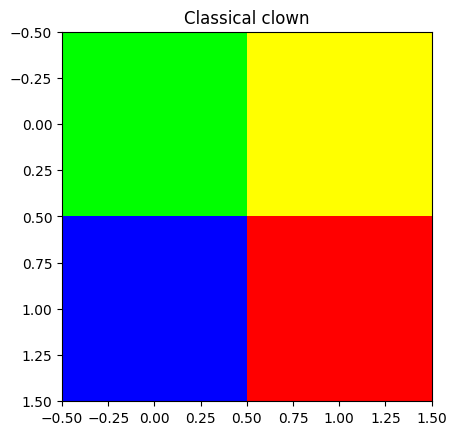

In [203]:
image = np.zeros((2,2,3))

image[:,:,0] = np.array(
           [0, 200, 0, 20]).reshape(2,2)

image[:,:,1] = np.array(
           [150, 150, 0, 0]).reshape(2,2)

image[:,:,2] = np.array(
           [0, 0, 28, 0]).reshape(2,2)

plt.imshow(image.reshape(2,2,3))
plt.title('Classical clown')
plt.show()

In [232]:
def params(image):
    xqbits = math.log(image.shape[0],2)
    yqbits = math.log(image.shape[1],2)
    return int(xqbits), int(yqbits)
    
def rgb_circ(image):
    xqbit, yqbit = params(image)
    qr = QuantumRegister(xqbit + yqbit + 3) #3 stands for RGB qubits
    # color = qr[xqbit + yqbit:]
    # coordinate = qr[:xqbit + yqbit]
    cr = ClassicalRegister(xqbit + yqbit + 3, 'c')
    qc = QuantumCircuit(qr, cr)
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k,xqbit + yqbit - 1 - k)
        
    for i in range(xqbit + yqbit):
        qc.h(i)
    
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
        
        for i, pixel in enumerate(input_im):
            arr = list(range(xqbit + yqbit))
            arr.append(int(xqbit + yqbit + layer_num))
            cMry = RYGate(2*pixel, label=f'pixel{abs(i-3)}').control(xqbit + yqbit)
            
            to_not = "{0:b}".format(i).zfill(xqbit + yqbit)
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            #qc.barrier()
            qc.append(cMry, arr)  

            if i!=len(input_im)-1 or layer_num!=2:
                for j, bit in enumerate(to_not):
                    if int(bit):
                        qc.x(j)
                qc.barrier()
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k, xqbit + yqbit - 1 - k)
    
    qc.swap(-1, -3)

    qc.barrier()
    for i in range(xqbit + yqbit + 3):
        qc.measure(i, i)
    
    return qc

### Step 3. Circuit Execution

In [233]:
def run_qc(qc, shots=1000):    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=shots)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts(qc)
    return counts

### Step 4. Measurements interpretation

In [234]:
def reconstruct_rgb(image, counts, to_print=True):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)):
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter:
                    num.append((int(item[0][layer_num], 2), item[1]))
            nums.append(num)
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num}
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set]
        colors = []
        for num in nums:
            if len(num)==2:
                if num[0][0] == 0:
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if num[0][0] == 0:
                    colors.append(0)
                else:
                    colors.append(np.pi/2)
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        if to_print:
            print(output_im, '\n', (image.T)[layer_num].copy().flatten())
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    
    return np.array(output_ims).T

In [235]:
start = time.time()

qc = rgb_circ(image)
counts = run_qc(qc)
output_ims = reconstruct_rgb(image, counts, to_print = False)

end = time.time()
print(f"{end - start:.5f} sec")

0.06383 sec


C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\2394357060.py:5: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = aer_sim.run(qobj).result()


C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


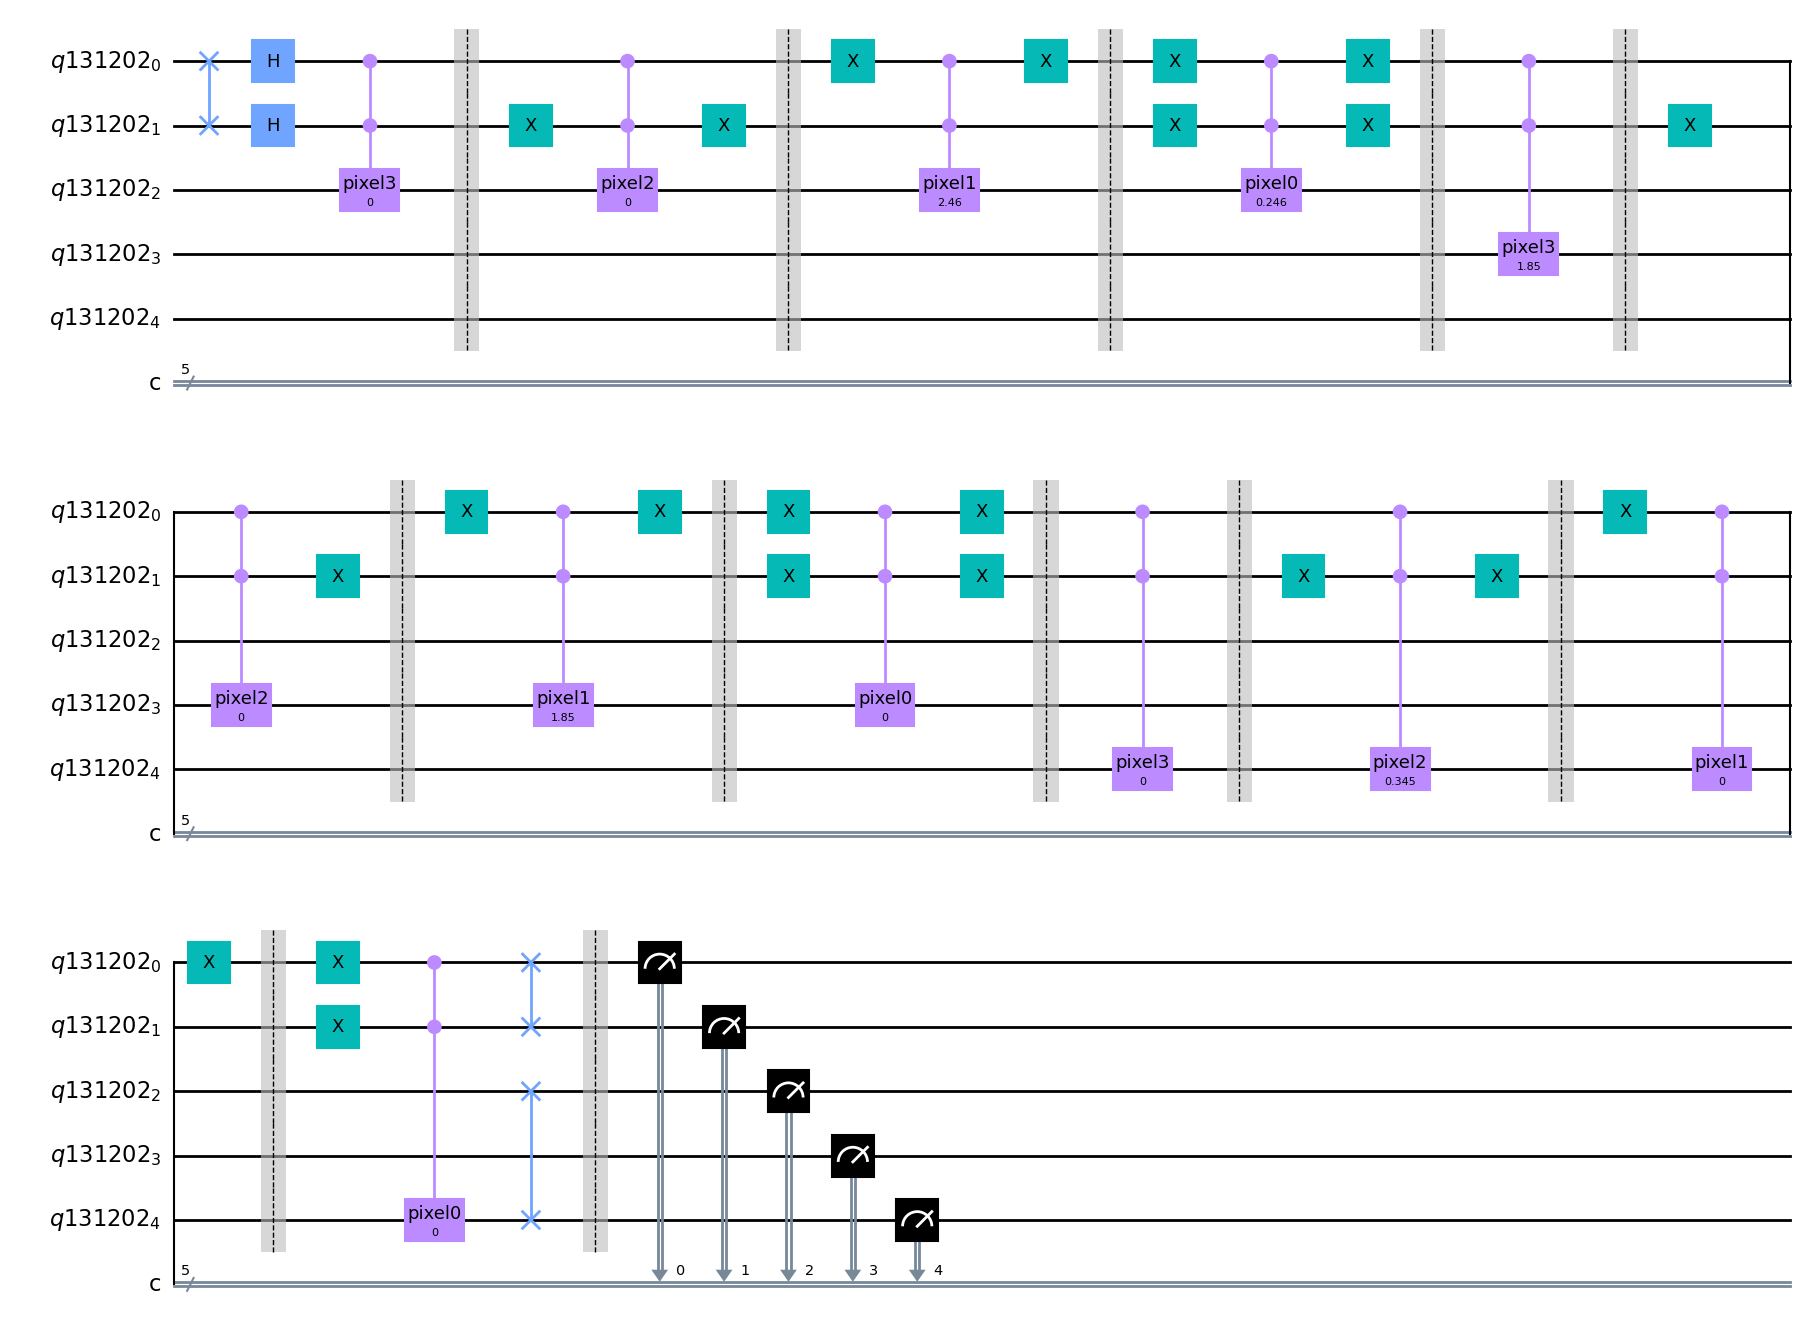

In [236]:
qc.draw('mpl')

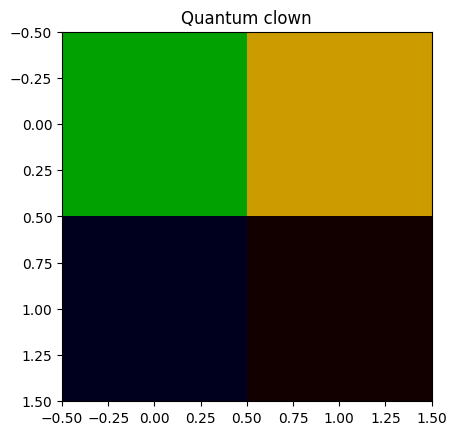

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


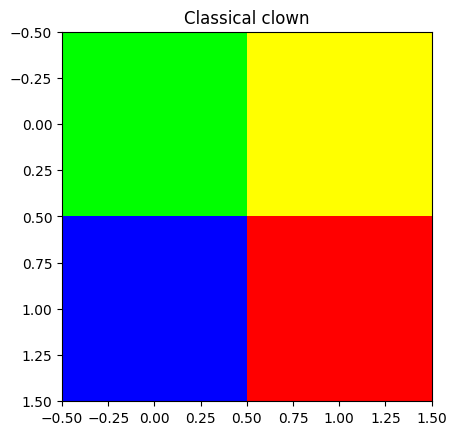

output_ims =  [[[  0 161   0]
  [204 155   0]]

 [[  0   0  30]
  [ 18   0   0]]]  and image =  [[[  0. 150.   0.]
  [200. 150.   0.]]

 [[  0.   0.  28.]
  [ 20.   0.   0.]]]


In [191]:
plt.imshow(output_ims)
plt.title('Quantum clown')
plt.show()

plt.title('Classical clown')
plt.imshow(image)
plt.show()

print("output_ims = ",output_ims, " and","image = ",image)

## Simulate MCQRI in IonQ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


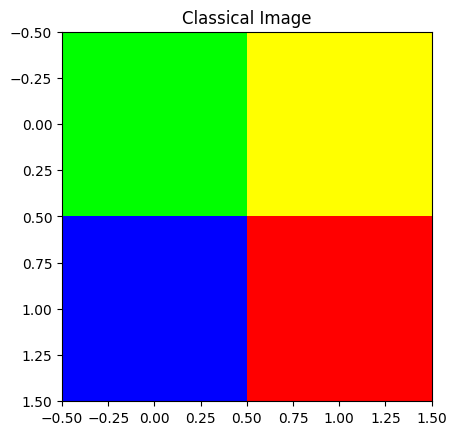

In [59]:
image = np.zeros((2,2,3))

image[:,:,0] = np.array(
           [0, 200, 0, 20]).reshape(2,2)

image[:,:,1] = np.array(
           [150, 150, 0, 0]).reshape(2,2)

image[:,:,2] = np.array(
           [0, 0, 28, 0]).reshape(2,2)

plt.imshow(image.reshape(2,2,3))
plt.title('Classical Image')
plt.show()

In [60]:
def params(image):
    xqbits = math.log(image.shape[0],2)
    yqbits = math.log(image.shape[1],2)
    return int(xqbits), int(yqbits)
    
def rgb_circ(image):
    xqbit, yqbit = params(image)
    qr = QuantumRegister(xqbit + yqbit + 3) #3 stands for RGB qubits
    # color = qr[xqbit + yqbit:]
    # coordinate = qr[:xqbit + yqbit]
    cr = ClassicalRegister(xqbit + yqbit + 3, 'c')
    qc = QuantumCircuit(qr, cr)
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k,xqbit + yqbit - 1 - k)
        
    for i in range(xqbit + yqbit):
        qc.h(i)
    
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
        
        for i, pixel in enumerate(input_im):
            arr = list(range(xqbit + yqbit))
            arr.append(int(xqbit + yqbit + layer_num))
            cMry = RYGate(2*pixel).control(xqbit + yqbit)
            
            to_not = "{0:b}".format(i).zfill(xqbit + yqbit)
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()
            qc.append(cMry, arr)  

            if i!=len(input_im)-1 or layer_num!=2:
                for j, bit in enumerate(to_not):
                    if int(bit):
                        qc.x(j)
                qc.barrier()
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k, xqbit + yqbit - 1 - k)
    
    qc.swap(-1, -3)

    qc.barrier()
    for i in range(xqbit + yqbit + 3):
        qc.measure(i, i)
    
    return qc

In [62]:
def run_qc(qc):
    simulator_backend = provider.get_backend("ionq_simulator")
    t_qc = transpile(qc, simulator_backend)
    job = simulator_backend.run(t_qc)
    result = job.result()
    counts = result.get_counts()
    return counts

In [61]:
def reconstruct_rgb(image, counts, to_print=True):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)):
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter:
                    num.append((int(item[0][layer_num], 2), item[1]))
            nums.append(num)
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num}
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set]
        colors = []
        for num in nums:
            if len(num)==2:
                if num[0][0] == 0:
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if num[0][0] == 0:
                    colors.append(0)
                else:
                    colors.append(np.pi/2)
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        if to_print:
            print(output_im, '\n', (image.T)[layer_num].copy().flatten())
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    
    return np.array(output_ims).T

In [63]:
start = time.time()

qc = rgb_circ(image)
counts = run_qc(qc)
output_ims = reconstruct_rgb(image, counts, to_print = False)

end = time.time()
print(f"{end - start:.5f} sec")

8.60331 sec


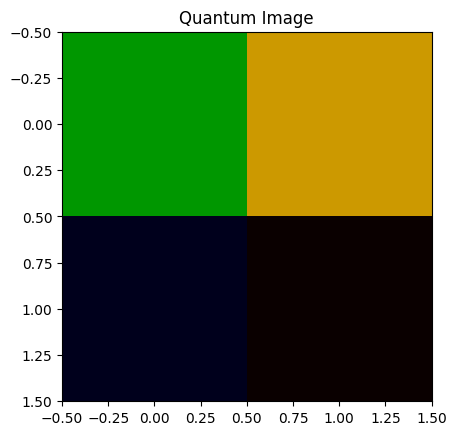

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


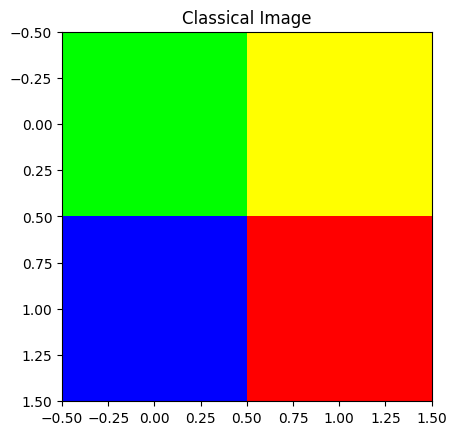

output_ims =  [[[  0 151   0]
  [204 153   0]]

 [[  0   0  28]
  [ 10   0   0]]]  and image =  [[[  0. 150.   0.]
  [200. 150.   0.]]

 [[  0.   0.  28.]
  [ 20.   0.   0.]]]


In [64]:
plt.imshow(output_ims)
plt.title('Quantum Image')
plt.show()

plt.title('Classical Image')
plt.imshow(image)
plt.show()

print("output_ims = ",output_ims, " and","image = ",image)

# Poster Algorithm Compare

## FRQI on IonQ for Poster

In [ ]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

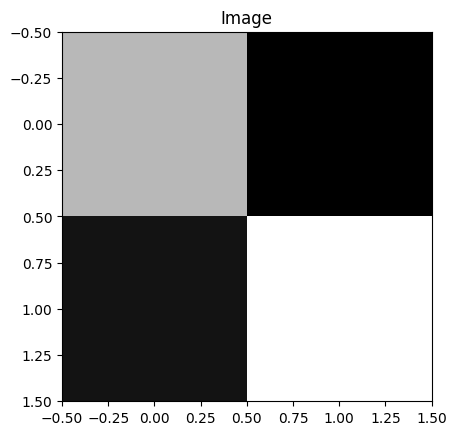

In [ ]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\2216121581.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


[193, 90, 100, 234] 
 [194  90 101 234]
10.96380 sec


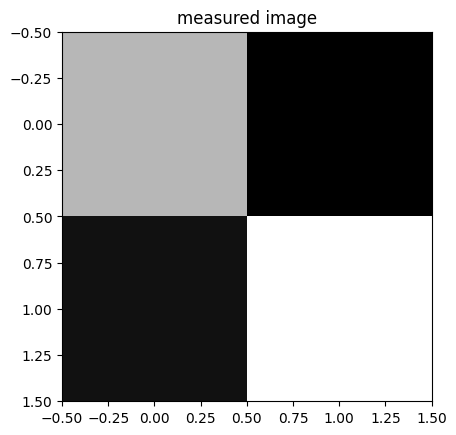

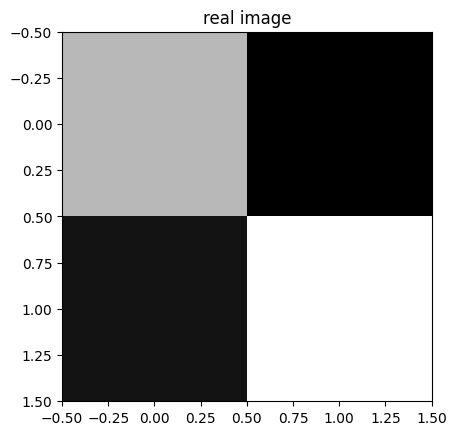

In [ ]:
start = time.time()

input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_oqim = simulator_backend.run(t_qc_image, shots=65536)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)


end = time.time()

print(f"{end - start:.5f} sec")

plot_to_compare(np.array(classical_colors).reshape(image.shape), image)

## MCQRI on IonQ for Poster

In [13]:
from qiskit.circuit.library.standard_gates.ry import RYGate

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


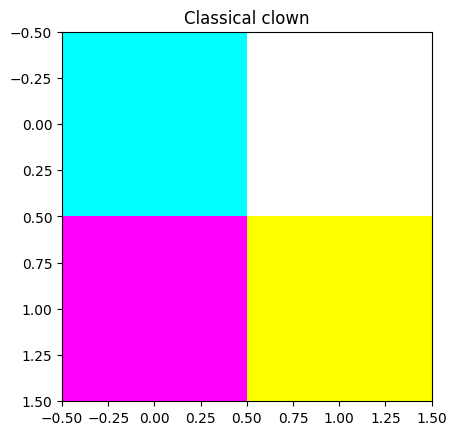

In [27]:
image = np.zeros((2,2,3))
image[:,:,0] = np.array(
           [
            0, 255, 255, 255]).reshape(2,2)

image[:,:,1] = np.array(
           [255, 255,  0, 255]).reshape(2,2)

image[:,:,2] = np.array(
           [255, 255, 255, 0]).reshape(2,2)

plt.imshow(image.reshape(2,2,3))
plt.title('Classical clown')
plt.show()

In [33]:
def params(image):
    xqbits = math.log(image.shape[0],2)
    yqbits = math.log(image.shape[1],2)
    return int(xqbits), int(yqbits)
    
def rgb_circ(image):
    xqbit, yqbit = params(image)
    qr = QuantumRegister(xqbit + yqbit + 3) #3 stands for RGB qubits
    # color = qr[xqbit + yqbit:]
    # coordinate = qr[:xqbit + yqbit]
    cr = ClassicalRegister(xqbit + yqbit + 3, 'c')
    qc = QuantumCircuit(qr, cr)
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k,xqbit + yqbit - 1 - k)
        
    for i in range(xqbit + yqbit):
        qc.h(i)
    
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
        
        for i, pixel in enumerate(input_im):
            arr = list(range(xqbit + yqbit))
            arr.append(int(xqbit + yqbit + layer_num))
            cMry = RYGate(2*pixel).control(xqbit + yqbit)
            
            to_not = "{0:b}".format(i).zfill(xqbit + yqbit)
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()
            qc.append(cMry, arr)  

            if i!=len(input_im)-1 or layer_num!=2:
                for j, bit in enumerate(to_not):
                    if int(bit):
                        qc.x(j)
                qc.barrier()
    
    for k in range(int(np.floor((xqbit + yqbit)/2))):
        qc.swap(k, xqbit + yqbit - 1 - k)
    
    qc.swap(-1, -3)

    qc.barrier()
    for i in range(xqbit + yqbit + 3):
        qc.measure(i, i)
    
    return qc

In [34]:
def reconstruct_rgb(image, counts, to_print=True):
    output_ims = []
    for layer_num, input_im in enumerate(image.T):
        input_im = input_im.flatten()
        nums = []
        for iter in range(len(input_im)):
            flag = 0
            num = []
            for item in counts.items():
                if int(item[0][3:], 2)==iter:
                    num.append((int(item[0][layer_num], 2), item[1]))
            nums.append(num)
        for l, num in enumerate(nums):
            my_set = {x[0] for x in num}
            nums[l] = [(i,sum(x[1] for x in num if x[0] == i)) for i in my_set]
        colors = []
        for num in nums:
            if len(num)==2:
                if num[0][0] == 0:
                    color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
                else:
                    color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                    colors.append(color)
            else:
                if num[0][0] == 0:
                    colors.append(0)
                else:
                    colors.append(np.pi/2)
        output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
        if to_print:
            print(output_im, '\n', (image.T)[layer_num].copy().flatten())
        output_ims.append(output_im.reshape(image[:,:,0].shape))
    
    return np.array(output_ims).T

9.88095 sec


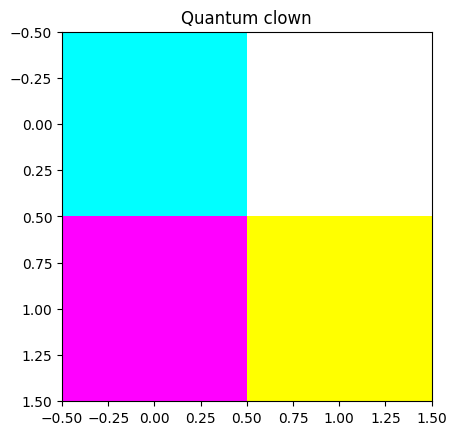

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


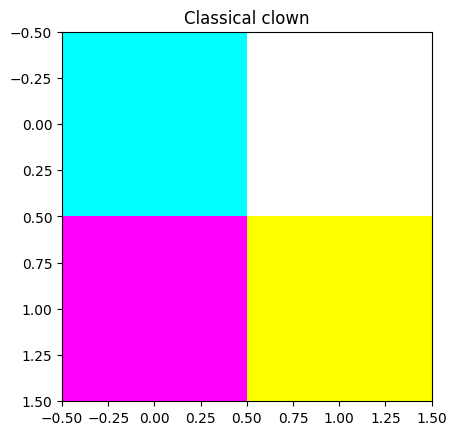

In [35]:
start = time.time()
def run_qc(qc, shots=65536):        
    simulator_backend = provider.get_backend("ionq_simulator")
    t_qc_image = transpile(qc, simulator_backend)
    job = simulator_backend.run(t_qc_image, shots=shots)
    result = job.result()
    counts = result.get_counts()
    return counts

qc = rgb_circ(image)
counts = run_qc(qc)
output_ims = reconstruct_rgb(image, counts, to_print = False)

end = time.time()

print(f"{end - start:.5f} sec")

plt.imshow(output_ims)
plt.title('Quantum clown')
plt.show()
plt.title('Classical clown')
plt.imshow(image)
plt.show()

## NEQR on IonQ for Poster

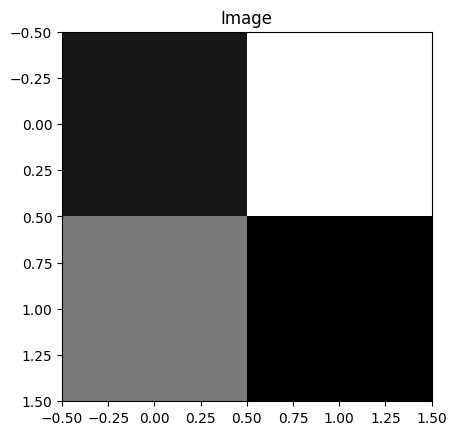

In [255]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\1858574490.py:8: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(intensity)


8.70551 sec


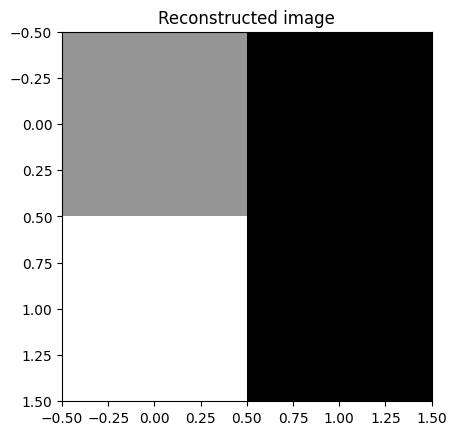

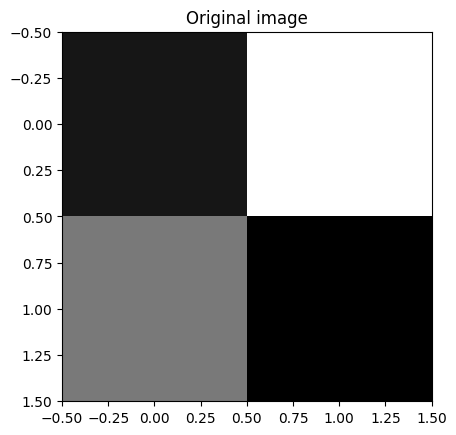

[ 93.   0. 159.   0.] 
 [ 27 202 102  10]


In [256]:
start = time.time()
indx = QuantumRegister(w_bits+h_bits, 'indx')
intensity = QuantumRegister(8,'intensity')
cr = ClassicalRegister(len(indx)+len(intensity), 'cr')
qc_image = QuantumCircuit(intensity, indx, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(intensity)
qc_image.h(indx)
for i, pixel in enumerate(input_im):
    pixel_bin = "{0:b}".format(pixel).zfill(len(intensity))
    position = "{0:b}".format(i).zfill(len(indx))
    for j, coord in enumerate(position):
        if int(coord):
            qc_image.x(qc_image.num_qubits-j-1)
    for idx, px_value in enumerate(pixel_bin[::-1]):
        if(px_value=='1'):
            control_qubits = list(range(intensity.size, intensity.size + indx.size))
            target_qubit = intensity[idx]
            qc_image.mcx(control_qubits, target_qubit)
    if i!=len(input_im) - 1:
        for j, coord in enumerate(position):
            if int(coord):
                qc_image.x(qc_image.num_qubits-j-1)
    qc_image.barrier()
qc_image.measure(range(qc_image.num_qubits),range(cr.size))
simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, simulator_backend)
job_neqr = simulator_backend.run(t_qc_image, shots=65536)
result_neqr = job_neqr.result()
counts_neqr = result_neqr.get_counts()
out_pixels = []
for item in counts_neqr:
    out_pixels.append((int(item[0:w_bits+h_bits], 2), int(item[w_bits+h_bits:],2)))
out_image = np.zeros((1, len(input_im)))
for pixel in out_pixels:
    out_image[0][pixel[0]] = pixel[1]
out_image = np.reshape(out_image, (image.shape))
end = time.time()
print(f"{end - start:.5f} sec")

plt.imshow(out_image, cmap='gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap='gray')
plt.title('Original image')
plt.show()
print(out_image.flatten(), '\n', image.flatten())

## QSMC and QSNC on IonQ for Poster

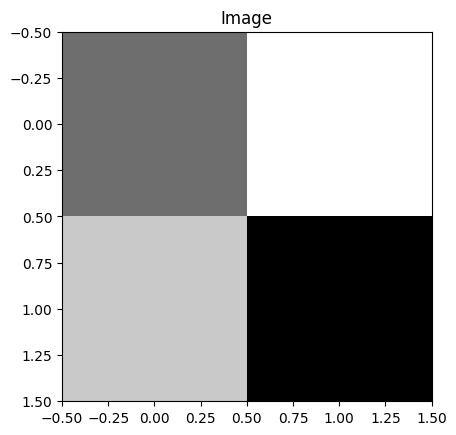

In [267]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1

In [268]:
start = time.time()
im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1
O = QuantumRegister(num_ind_bits, 'o_reg')
color = QuantumRegister(1,'color')
coordinate = QuantumRegister(1, 'coordinate')
cr = ClassicalRegister(O.size+color.size+coordinate.size, "cl_reg")

qc_image = QuantumCircuit(color, coordinate, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(color)
qc_image.i(coordinate)
qc_image.h(O)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            cry = RYGate(2 *theta, label=f'{abs(i-3)} theta').control(2)
            qc_image.append(cry, [3,2,0])
            qc_image.barrier()
        else:
            cry = RYGate(2 *phi, label=f'{abs(i-3)} phi').control(2)
            qc_image.append(cry, [3,2,1])
       
    qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
                
    qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))    

simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_qsmc = simulator_backend.run(t_qc_image, shots=65536)
result_qsmc = job_qsmc.result()
counts_qsmc = result_qsmc.get_counts()

classical_colors = []
classical_coords = []

for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts_qsmc.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
                color_list.append((key[0], amount))
                coord_list.append((key[1], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
print('the meauserd colors are \n {} \n the input colors are \n {}'.format(classical_colors, im_list))
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
print('the meauserd coordinates are \n {}'.format(classical_coords))
output_im = classical_colors.reshape(image.shape)

end = time.time()
print(f"{end - start:.5f} sec")

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\1213144194.py:19: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(color)
C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\1213144194.py:20: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(coordinate)


the meauserd colors are 
 [118 243 198  21] 
 the input colors are 
 [118 244 197  22]
the meauserd coordinates are 
 [0 1 1 2]
36.17781 sec


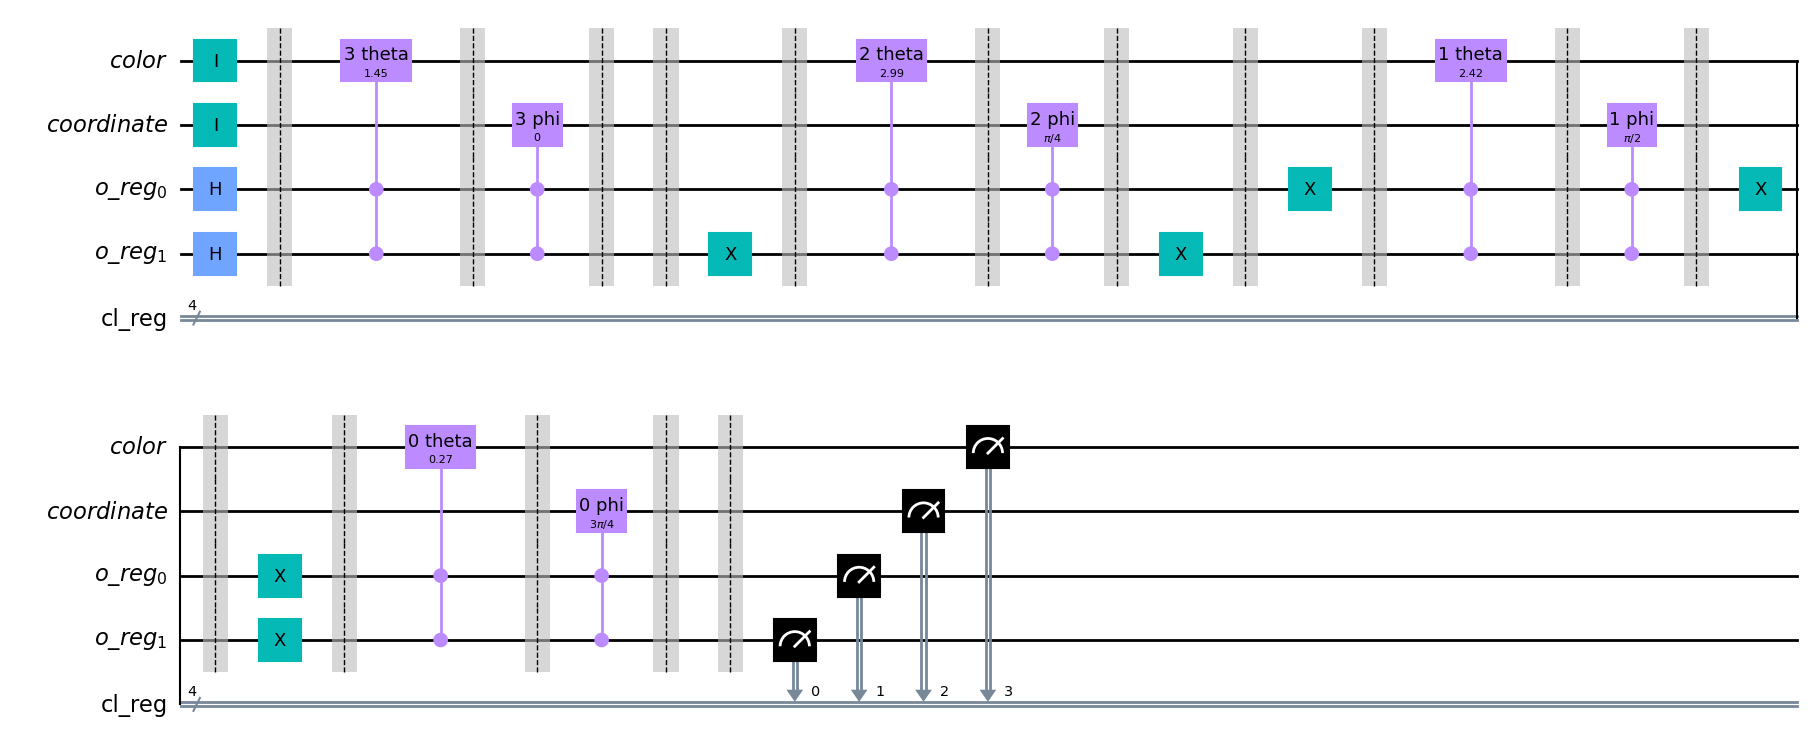

In [269]:
qc_image.draw('mpl')

In [270]:
controls_

[Qubit(QuantumRegister(2, 'o_reg'), 0), Qubit(QuantumRegister(2, 'o_reg'), 1)]

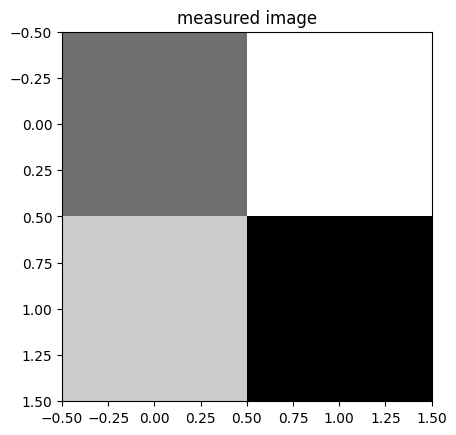

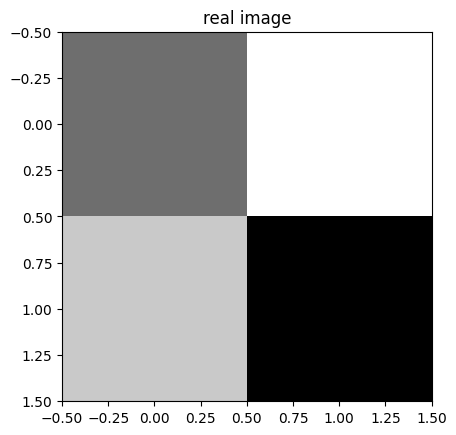

In [271]:
plot_to_compare(output_im, image)

In [276]:
color_list

[('0', 2415), ('1', 42), ('0', 14008), ('1', 259)]

In [277]:
classical_colors

array([118, 243, 198,  21])

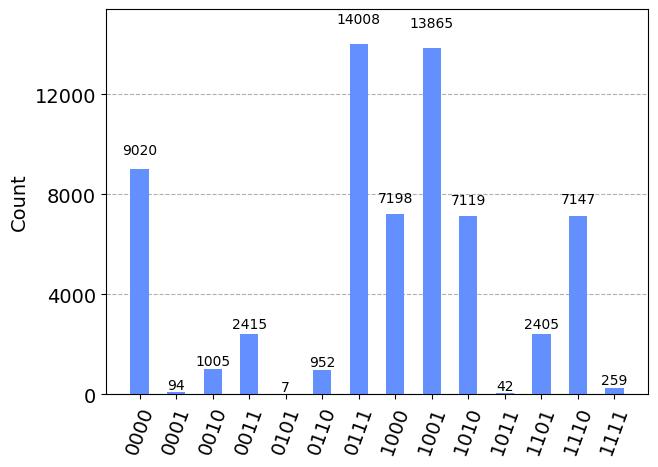

In [275]:
plot_histogram(counts_qsmc)

## GQIR on IonQ for Poster

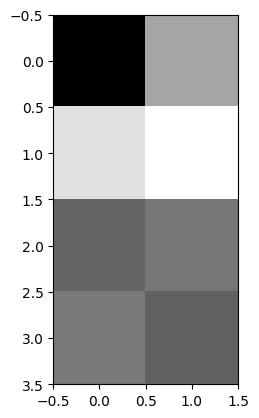

In [2]:
image = np.random.uniform(low=0, high=255, size=(4,2)).astype(int)
plt.imshow(image, cmap = 'gray')

In [3]:
start = time.time()
x = int(np.ceil(math.log(image.shape[0], 2)))
if int(x) == 0: x = 1
y = int(np.ceil(math.log(image.shape[1], 2)))
if int(y) == 0: y = 1
q = 8

color = QuantumRegister(q, 'color')
y_ax = QuantumRegister(y, 'y axis')
x_ax = QuantumRegister(x, 'x axis')
classic = ClassicalRegister(x+y+q, 'classic')
qc = QuantumCircuit(color, y_ax, x_ax, classic)

qc.i(color)
qc.h(x_ax)
qc.h(y_ax)
qc.barrier()
controls_ = []
for i, _ in enumerate(x_ax):
    controls_.extend([x_ax[i]])
for i, _ in enumerate(y_ax):
    controls_.extend([y_ax[i]])  
for xi in range(image.shape[0]):
    xi_bin = "{0:b}".format(xi).zfill(x_ax.size)
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])  
    qc.barrier()
    for yi in range(image.shape[1]):
        yi_bin = "{0:b}".format(yi).zfill(y_ax.size)
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i]) 
        qc.barrier()
        intensity_bin = "{0:b}".format(image[xi, yi]).zfill(len(color))
        xg = XGate(None).control(len(controls_))
        target = []
        for i, bit in enumerate(intensity_bin):
            if int(bit):
                qc.mcx(controls_, color[i])
        qc.barrier()
        for i, bit in enumerate(yi_bin):
            if not int(bit):
                qc.x(y_ax[i])
        qc.barrier()
    for i, bit in enumerate(xi_bin):
        if not int(bit):
            qc.x(x_ax[i])
    qc.barrier()

qc.measure(x_ax, range(x_ax.size))
qc.measure(y_ax, range(x_ax.size, x_ax.size+y_ax.size))
qc.measure(color, range(x_ax.size+y_ax.size,x_ax.size+y_ax.size+color.size))

simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc, simulator_backend)
job_gqir = simulator_backend.run(t_qc_image, shots=65536)
result_gqir = job_gqir.result()
counts_gqir = result_gqir.get_counts()
counts_gqir = (["".join(list(reversed(c))) for c in counts_gqir])
print(counts_neqr)

out_pixels = []
for item in counts_gqir:
    out_pixels.append((int(item[0:x], 2), int(item[x:x+y],2), int(item[-q:],2)))
out_image = np.zeros(image.shape)
for pixel in out_pixels:
    if pixel[0]<out_image.shape[0]:
        if pixel[1]<out_image.shape[1]:
            out_image[pixel[0], pixel[1]] = pixel[2]

end = time.time()
print(f"{end - start:.5f} sec")

plt.imshow(out_image, cmap = 'gray')
plt.title('Reconstructed image')
plt.show()
plt.imshow(image, cmap = 'gray')
plt.title('Original image')
plt.show()
print(out_image, '\n', image)

C:\Users\HCI\AppData\Local\Temp\ipykernel_7328\977602559.py:14: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc.i(color)


NameError: name 'provider' is not defined

C:\Users\HCI\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


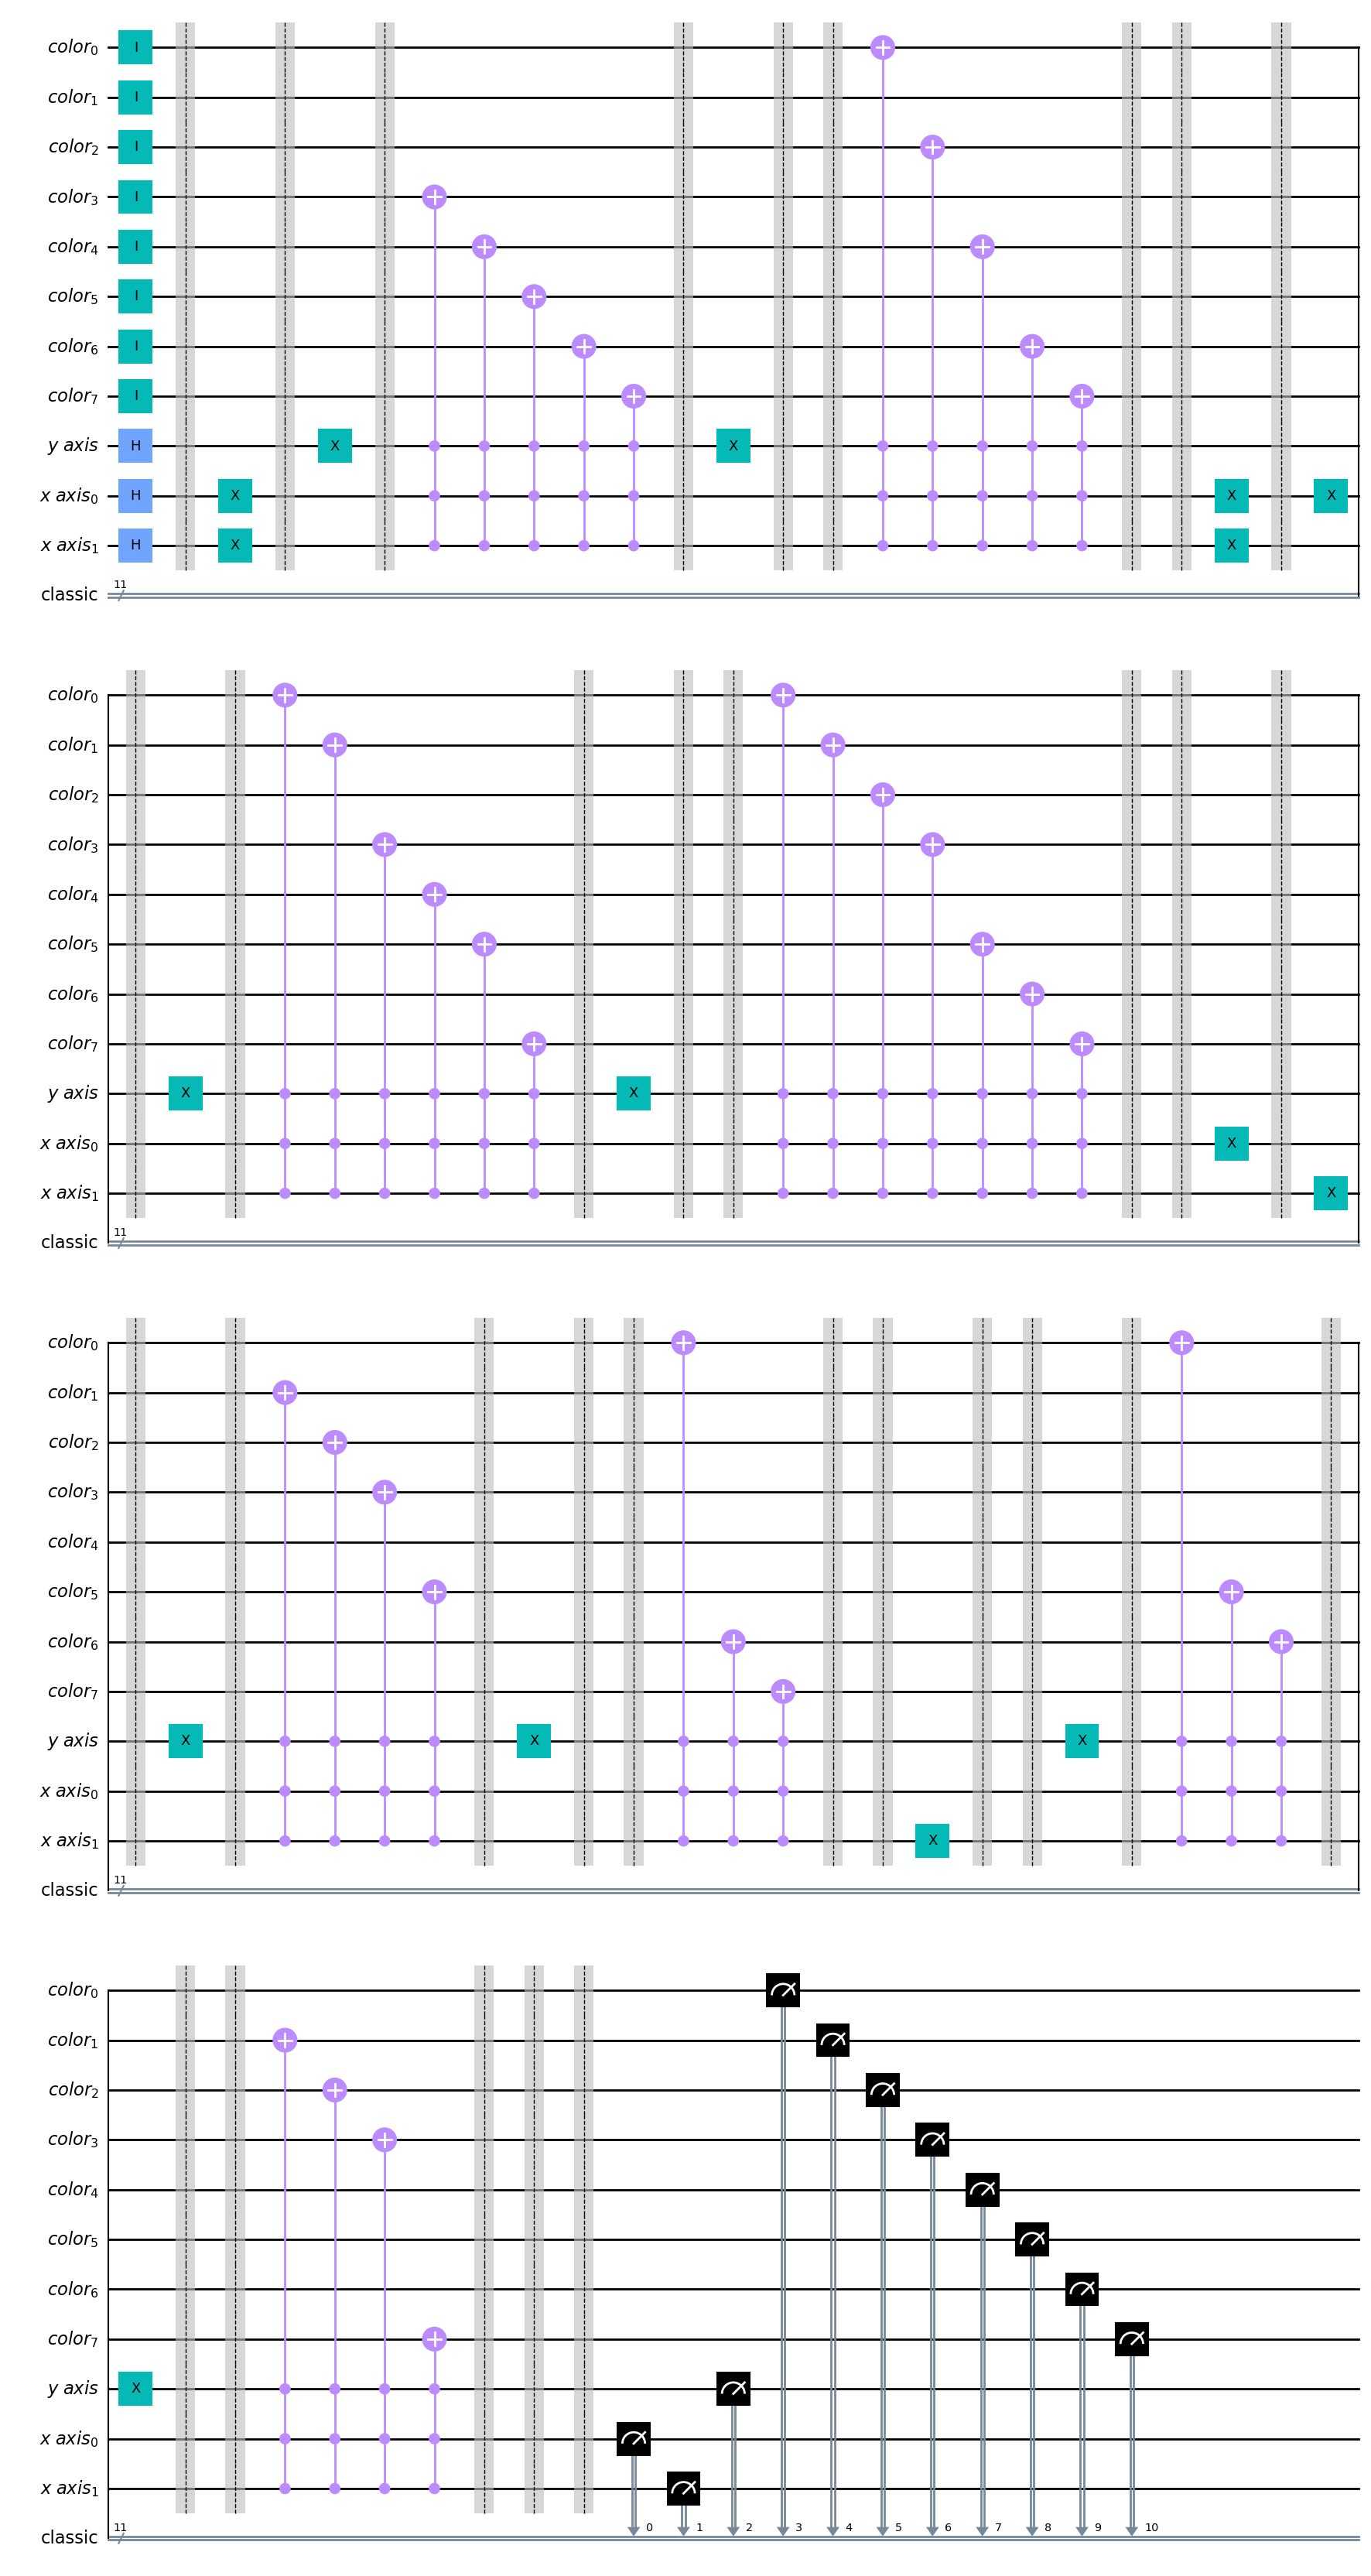

In [13]:
qc.draw('mpl')

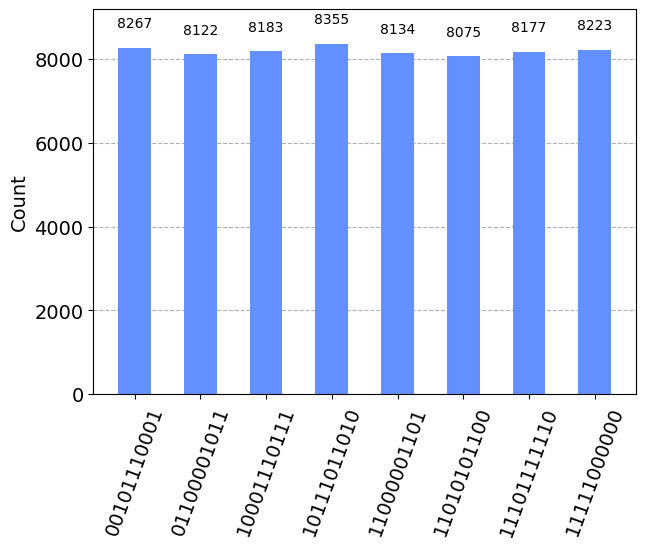

In [11]:
plot_histogram(counts_gqir)

## OQIM on IonQ for Poster

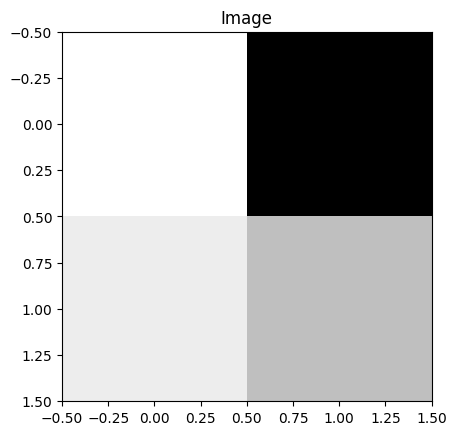

In [47]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
plt.imshow(image, cmap='gray')
plt.title('Image')
plt.show()

C:\Users\HCI\AppData\Local\Temp\ipykernel_14680\1800655617.py:24: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.i()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.id as direct replacement.
  qc_image.i(c)


the meauserd colors are 
 [150   0 138 113] 
 the input colors are 
 [151   0 140 113]
the meauserd coordinates are 
 [0 0 1 2]
15.57338 sec


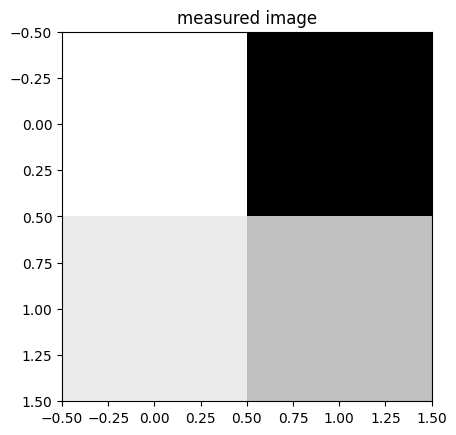

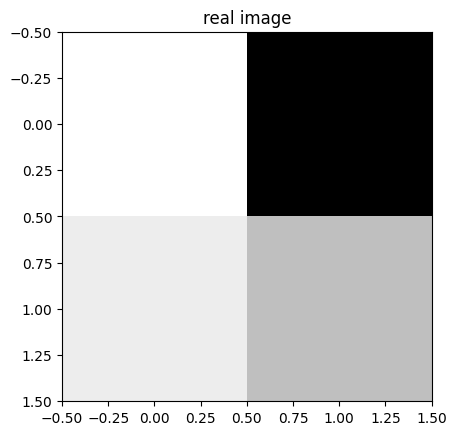

In [49]:
start = time.time()
w_bits = int(np.ceil(math.log(image.shape[1],2)))
h_bits = int(np.ceil(math.log(image.shape[0],2)))
if not w_bits: w_bits = 1
if not h_bits: h_bits = 1
im_list = image.flatten()
ind_list = sorted(range(len(im_list)), key=lambda k:im_list[k])
max_index = max(ind_list)
#now in angles: theta = intensity, phi = coordinate
thetas = np.interp(im_list, (0, 256), (0, np.pi/2))
phis = np.interp(range(len(im_list)), (0, len(im_list)), (0, np.pi/2))
num_ind_bits = int(np.ceil(math.log(len(im_list),2)))
if not num_ind_bits:
    num_ind_bits = 1

O = QuantumRegister(num_ind_bits, 'o_reg')
c = QuantumRegister(1,'c_reg')
p = QuantumRegister(1, 'p_reg')
cr = ClassicalRegister(O.size+c.size+p.size, "cl_reg")

qc_image = QuantumCircuit(c, p, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.i(c)
qc_image.h(O)
qc_image.h(p)
controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])
for i, _ in enumerate(p):
    controls_.extend([p[i]]) 

for i, (phi, theta) in enumerate(zip(phis, thetas)):
    qubit_index_bin = "{0:b}".format(i).zfill(num_ind_bits)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    
    for coord_or_intns in (0,1):
        if not coord_or_intns:
            qc_image.mcry(theta=2*theta,
                          q_controls=controls_,
                          q_target=c[0])
        else:
            qc_image.x(p)
            qc_image.mcry(theta=2*phi,
                          q_controls=controls_,
                          q_target=c[0])
            if i!=len(thetas) - 1:
                qc_image.x(p)
       
    # qc_image.barrier()
    
    if  i!=len(thetas) - 1:
        for k, qub_ind in enumerate(qubit_index_bin):
            if int(qub_ind):
                qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size))) 


simulator_backend = provider.get_backend("ionq_simulator")
t_qc_image = transpile(qc_image, simulator_backend)
job_oqim = simulator_backend.run(t_qc_image, shots=65536)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
classical_coords = []
for i in range(0, max_index+1):
    color_list = []
    coord_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[2:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            if not int(key[1]):
                color_list.append((key[0], amount))
            else:
                coord_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
        
    coord_amount = 0
    for coord, amount in coord_list:
        if not int(coord):
            coord_amount=coord_amount+amount
    try:
        coord = np.arccos((coord_amount/sum(n for _, n in coord_list))**(1/2))
        classical_coords.append(coord)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)
print('the meauserd colors are \n {} \n the input colors are \n {}'.format(classical_colors, im_list))
classical_coords = np.interp(classical_coords, (0, np.pi/2), (0, len(im_list))).astype(int)
print('the meauserd coordinates are \n {}'.format(classical_coords))
output_im = classical_colors.reshape(image.shape)

end = time.time()
print(f"{end - start:.5f} sec")

plot_to_compare(output_im, image)

# Time Complexity Compare

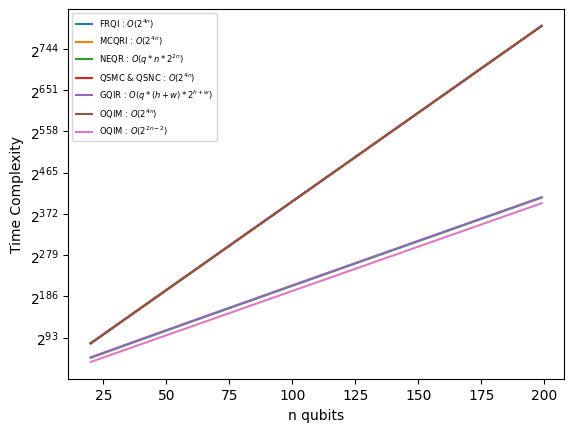

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# n qubits can represent 2**n pixels. Thus, Total number of used qubits are 2n qubits.

# Big-O represent of FRQI
n = np.arange(20,200)

n = n.astype(np.float64)

y_frqi = 2**(4*n)

# Big-O represent of NEQR

y_neqr = 8 * n*2**(2*n)


# Big-O represent of QSMC & QSNC 

y_qsmc = 2**(4*n)

# Big-O represent of MCQRI

y_mcqri = 2**(4*n)

# Big-O represent of GQIR
h =n
w = n

y_gqir  = []
for i in range(len(n)):
    sum = 0
    sum += h[i]
    sum += w[i]
    time = 8 *sum*2**(sum)
    y_gqir.append(time)

# Big-O represent of oqim

y_oqim = 2**(4*n)


y_ours = 2**(2*n-2)


plt.plot(n, y_frqi, label = 'FRQI : $O(2^{4n})$')
plt.plot(n, y_mcqri, label = 'MCQRI : $O(2^{4n})$')
plt.plot(n, y_neqr, label = 'NEQR : $O(q*n*2^{2n})$')
plt.plot(n, y_qsmc, label = 'QSMC & QSNC : $O(2^{4n})$')
plt.plot(n, y_gqir, label = 'GQIR : $O(q*(h+w)*2^{h+w})$')
plt.plot(n, y_oqim, label = 'OQIM : $O(2^{4n})$')
plt.plot(n, y_ours, label = 'OQIM : $O(2^{2n-2})$')



plt.xlabel('n qubits')
plt.ylabel('Time Complexity')
plt.yscale('log', base=2)
plt.legend(fontsize="6")

plt.show()